# CAISO Energy Storage Bid Analysis

<b>Author:</b> Neal Ma

<b>Date Created:</b> October 1, 2024

<b>Description:</b> This notebook analyzes CAISO Energy Storage bid data obtained from CAISO Daily Energy Storage Reports.

CAISO Average Price Data from LCG Consulting (http://www.energyonline.com/Data/GenericData.aspx?DataId=20)

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
import math

In [34]:
data_path = "./data/ES_BIDS/"
df = pd.read_parquet(data_path + "CAISO_ES_BIDS.parquet")

caiso_avg_price_df = pd.read_csv("./data/CAISOAvgPrice.csv")
caiso_avg_price_df["date"] = pd.to_datetime(caiso_avg_price_df["date"])
caiso_avg_price_df.set_index("date", inplace=True)
df = df.merge(caiso_avg_price_df, left_index=True, right_index=True, how="left")

C:\Users\Astro\AppData\Local\Temp\ipykernel_31616\2935140400.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  caiso_avg_price_df["date"] = pd.to_datetime(caiso_avg_price_df["date"])


In [35]:
bid_cols = [col for col in df.columns if "bid" in col]

bid_segments = {
    "ss": "Self Schedule",
    "1": "[-150, -100]",
    "2": "(-100, -50]",
    "3": "(-50, -15]",
    "4": "(-15, 0]",
    "5": "(0, 15]",
    "6": "(15, 50]",
    "7": "(50, 100]",
    "8": "(100, 200]",
    "9": "(200, 500]",
    "10": "(500, 1000]",
    "11": "(1000, 2000]",
}

In [36]:
y_1_date_range = [pd.Timestamp("2022-07-01"), pd.Timestamp("2023-07-01")]
y_2_date_range = [pd.Timestamp("2023-07-01"), pd.Timestamp("2024-07-01")]

y_1_df = df.loc[(df.index >= y_1_date_range[0]) & (df.index < y_1_date_range[1])]
y_2_df = df.loc[(df.index >= y_2_date_range[0]) & (df.index < y_2_date_range[1])]

In [37]:
AGGREGATION_GRANULARITY = "D"

# plot the capacity-normalized bids for every segment aggregated daily
bid_columns = [col for col in df.columns if "bid" in col] + ["price"]

# aggregate daily capacities (time-based average) from df
df_daily_aggregate = df.resample(AGGREGATION_GRANULARITY).mean()
df_daily_aggregate["bid_rtpd_neg_tot"] = sum(
    [df_daily_aggregate[col_name] for col_name in bid_columns if "rtpd_neg" in col_name]
)
df_daily_aggregate["bid_rtpd_pos_tot"] = sum(
    [df_daily_aggregate[col_name] for col_name in bid_columns if "rtpd_pos" in col_name]
)
df_daily_aggregate["bid_ifm_neg_tot"] = sum(
    [df_daily_aggregate[col_name] for col_name in bid_columns if "ifm_neg" in col_name]
)
df_daily_aggregate["bid_ifm_pos_tot"] = sum(
    [df_daily_aggregate[col_name] for col_name in bid_columns if "ifm_pos" in col_name]
)

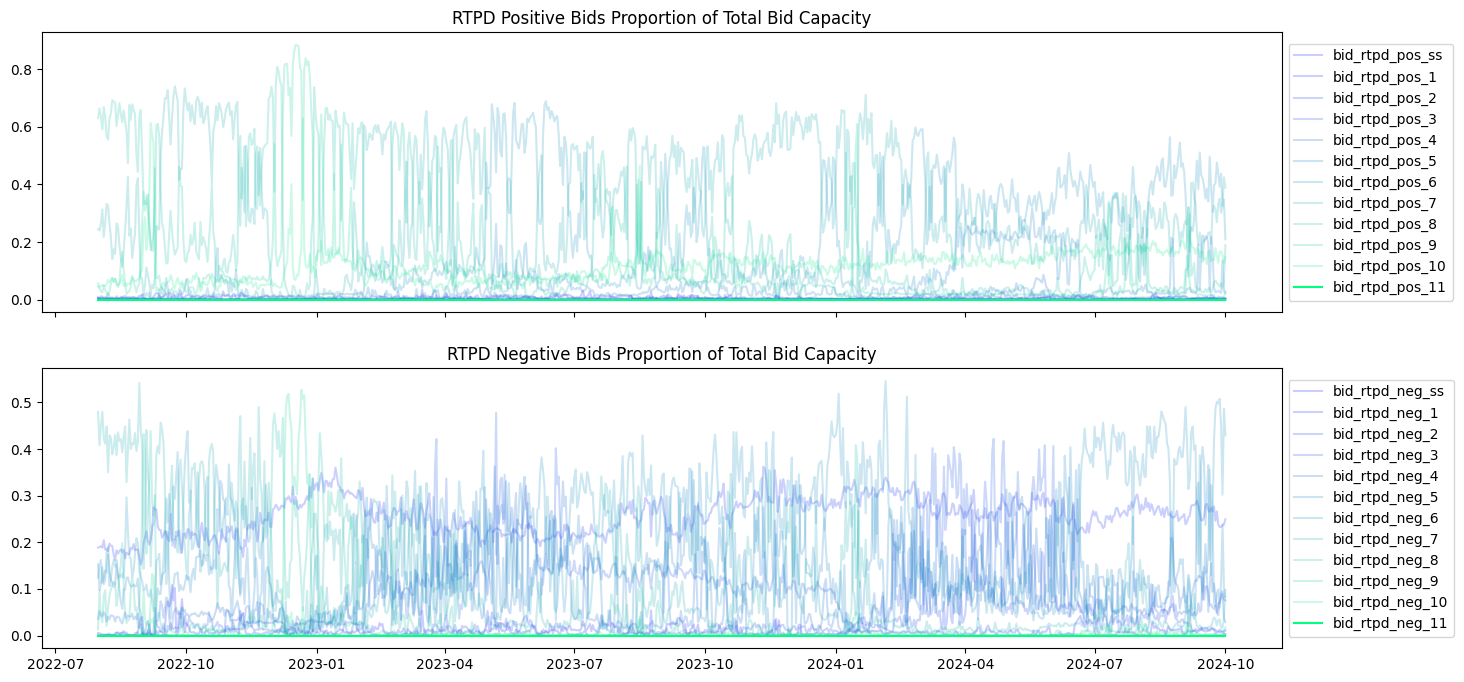

In [7]:
# plot rtpd
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# set interest segment... all other segments have lower opacities
interest_segment = "11"

# Get the colormap
cmap = plt.get_cmap("winter")
colors = cmap(np.linspace(0, 1, len([col for col in bid_columns if "rtpd_pos" in col])))

# Plot rtpd_pos_x proportions with lowered opacity for non-interest segments
for i, col in enumerate([col for col in bid_columns if "rtpd_pos" in col]):
    if interest_segment in col:
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_pos_tot"],
            label=col,
            color=colors[i],
        )
    else:
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_pos_tot"],
            label=col,
            color=colors[i],
            alpha=0.2,
        )
axs[0].set_title("RTPD Positive Bids Proportion of Total Bid Capacity")

# Plot rtpd_neg_x proportions with lowered opacity for non-interest segments
for i, col in enumerate([col for col in bid_columns if "rtpd_neg" in col]):
    if interest_segment in col:
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_neg_tot"],
            label=col,
            color=colors[i],
        )
    else:
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_neg_tot"],
            label=col,
            color=colors[i],
            alpha=0.2,
        )
axs[1].set_title("RTPD Negative Bids Proportion of Total Bid Capacity")

# Move the legend off the right side of the plot
axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
axs[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

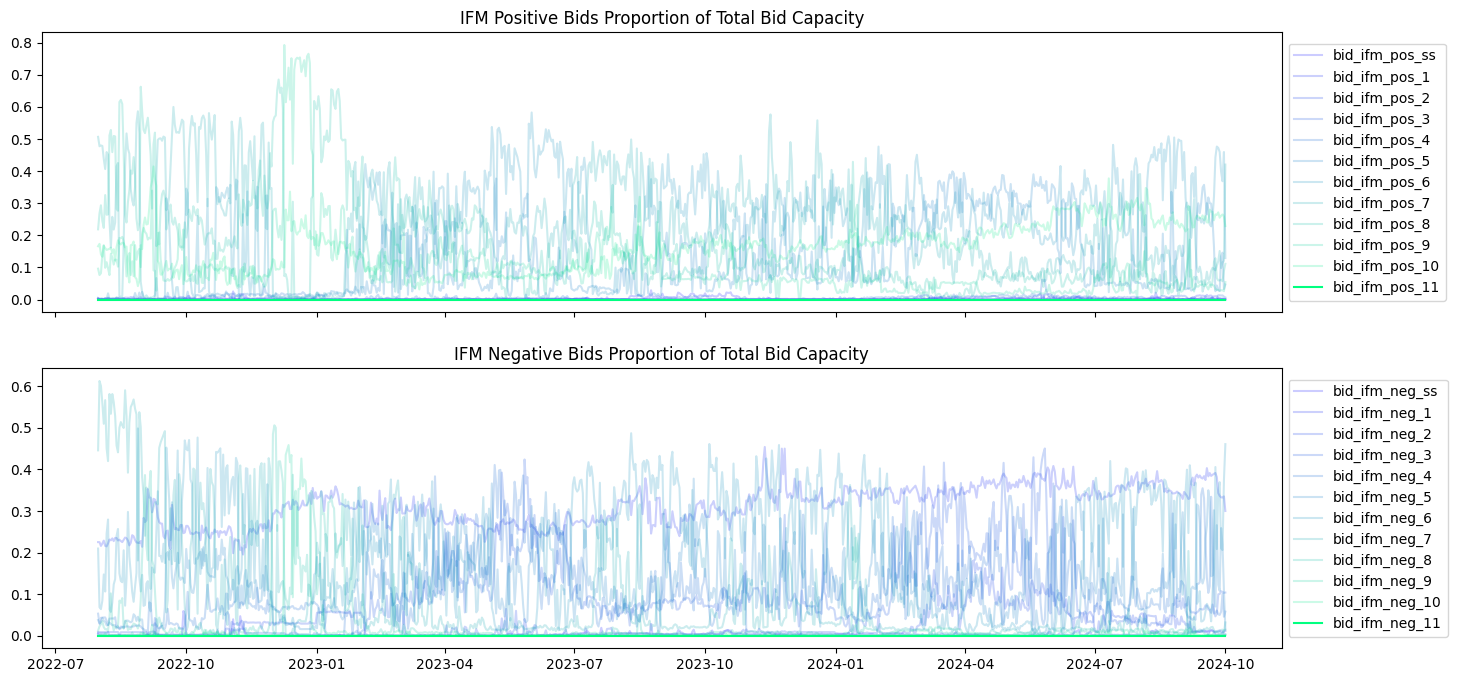

In [8]:
# plot ifm
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Plot ifm_pos_x proportions with lowered opacity for non-interest segments
for i, col in enumerate([col for col in bid_columns if "ifm_pos" in col]):
    if interest_segment in col:
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_pos_tot"],
            label=col,
            color=colors[i],
        )
    else:
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_pos_tot"],
            label=col,
            color=colors[i],
            alpha=0.2,
        )
axs[0].set_title("IFM Positive Bids Proportion of Total Bid Capacity")

# Plot ifm_neg_x proportions with lowered opacity for non-interest segments
for i, col in enumerate([col for col in bid_columns if "ifm_neg" in col]):
    if interest_segment in col:
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_neg_tot"],
            label=col,
            color=colors[i],
        )
    else:
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_neg_tot"],
            label=col,
            color=colors[i],
            alpha=0.2,
        )
axs[1].set_title("IFM Negative Bids Proportion of Total Bid Capacity")

# Move the legend off the right side of the plot
axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
axs[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

ss


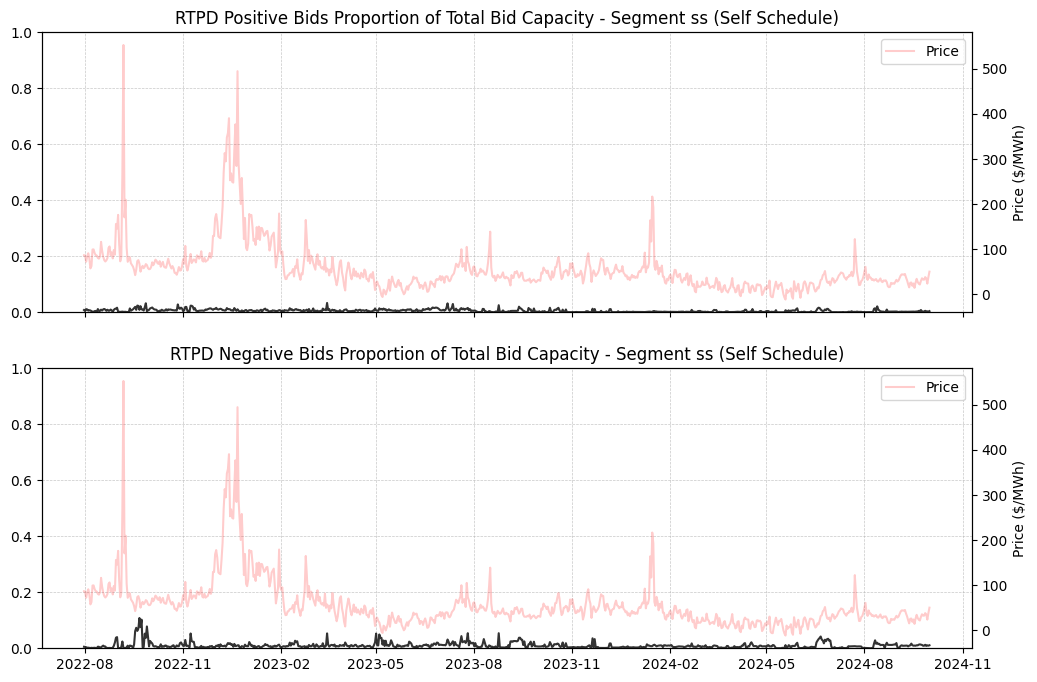

-0.00011355178591170188
1


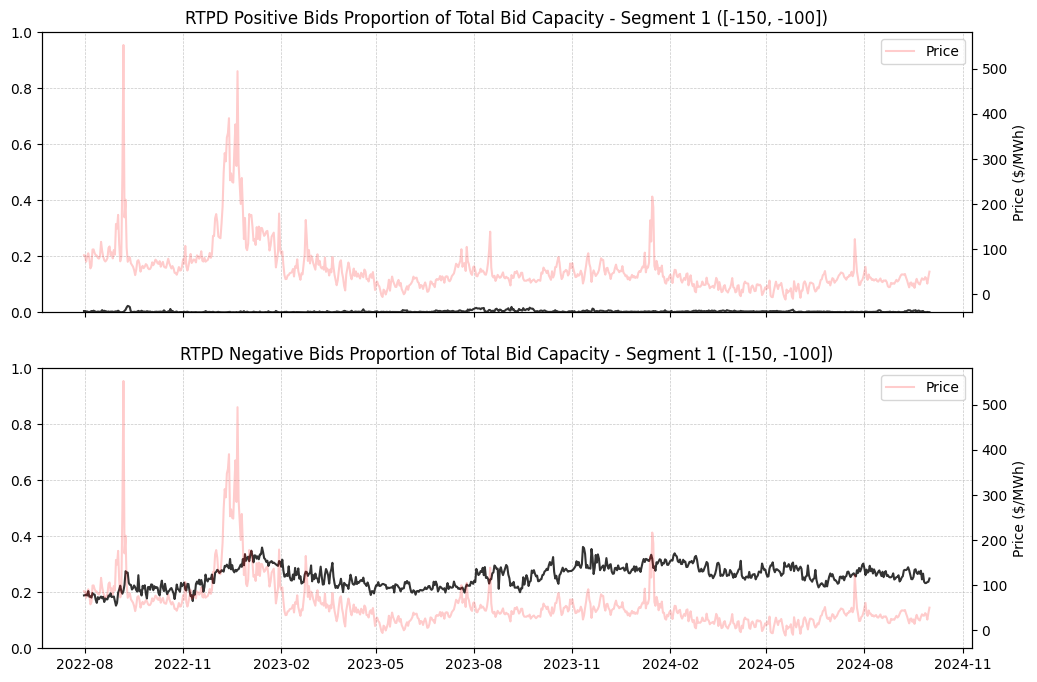

-0.1405205638549434
2


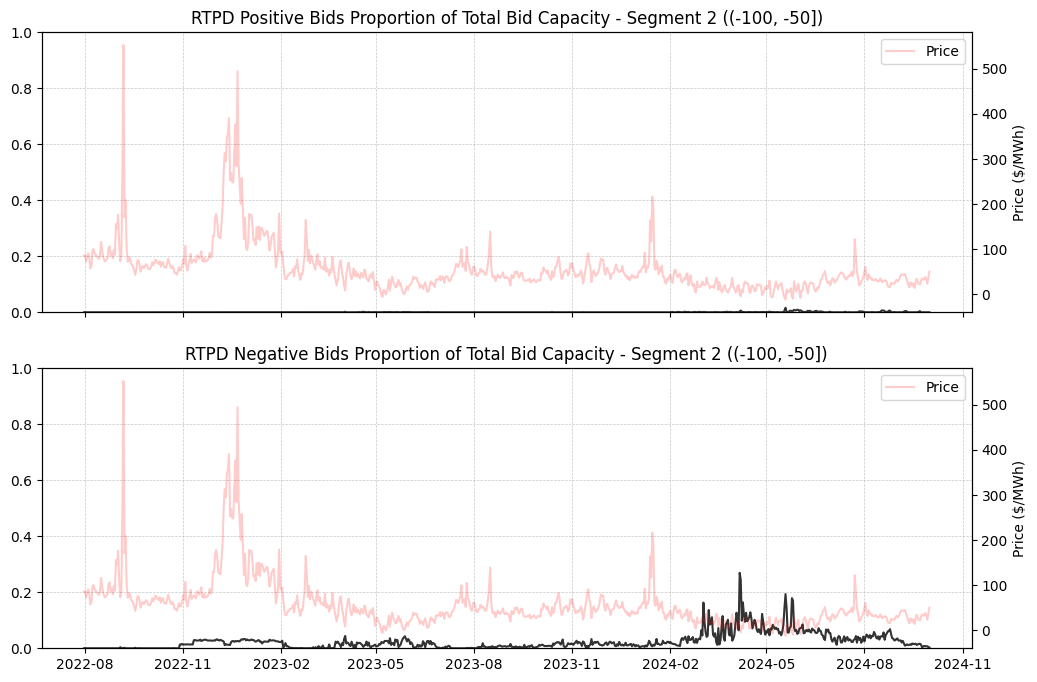

0.0
3


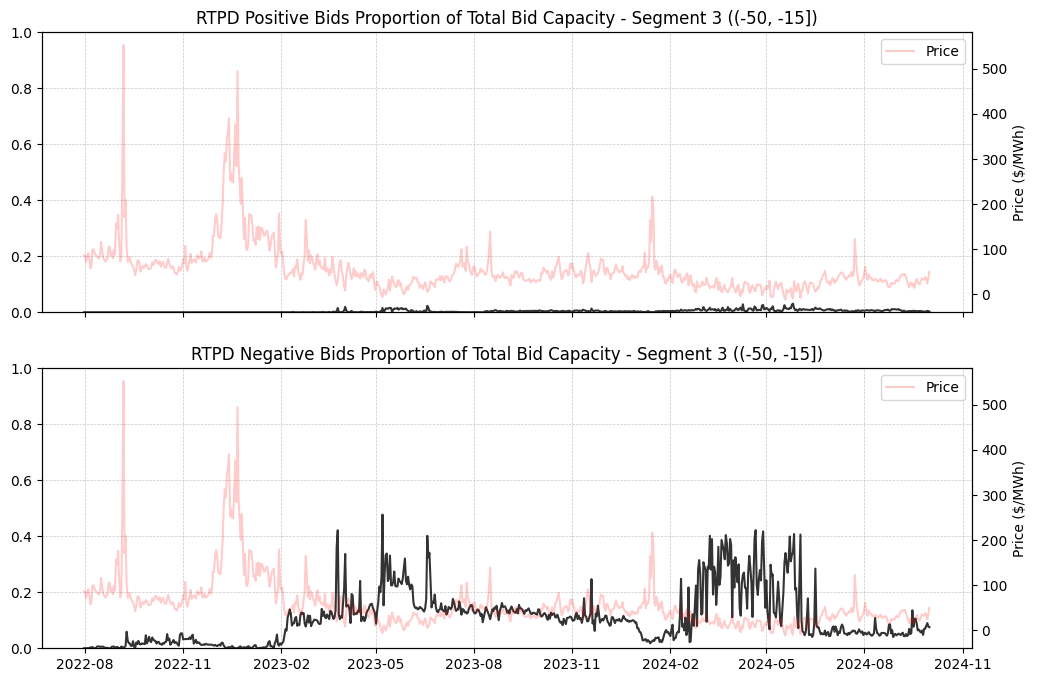

0.0
4


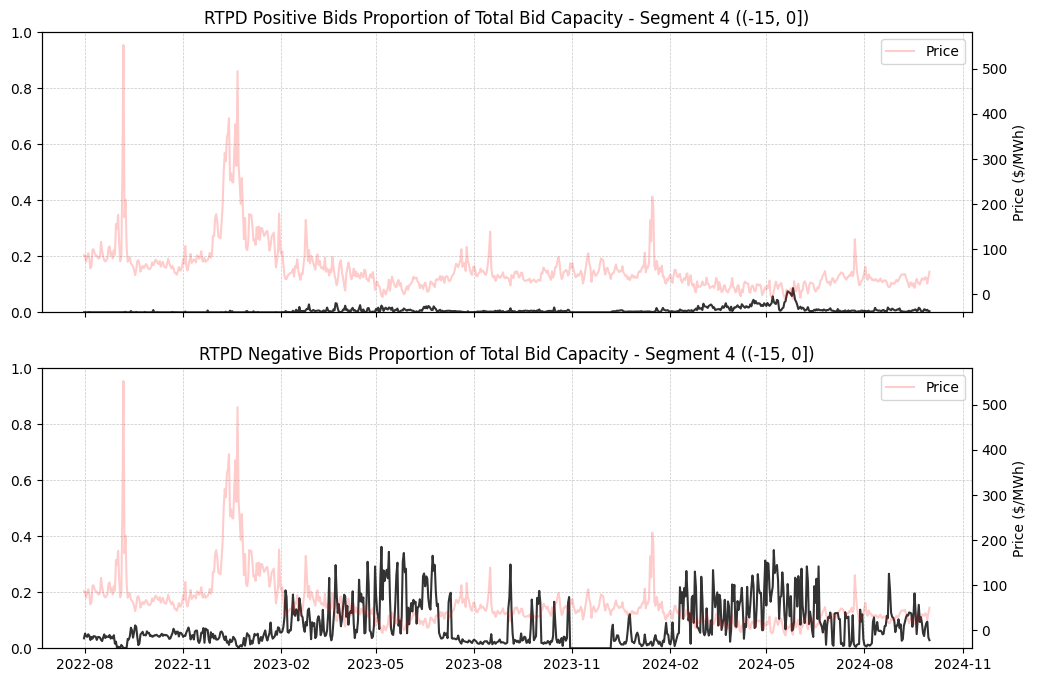

0.0
5


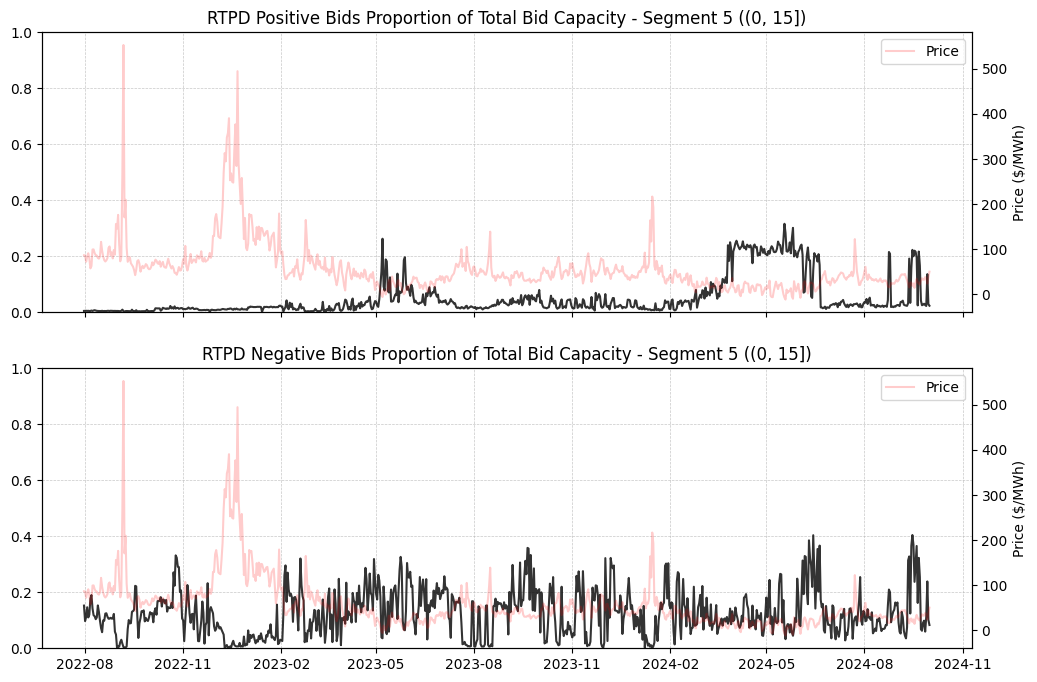

-0.00023496312279750473
6


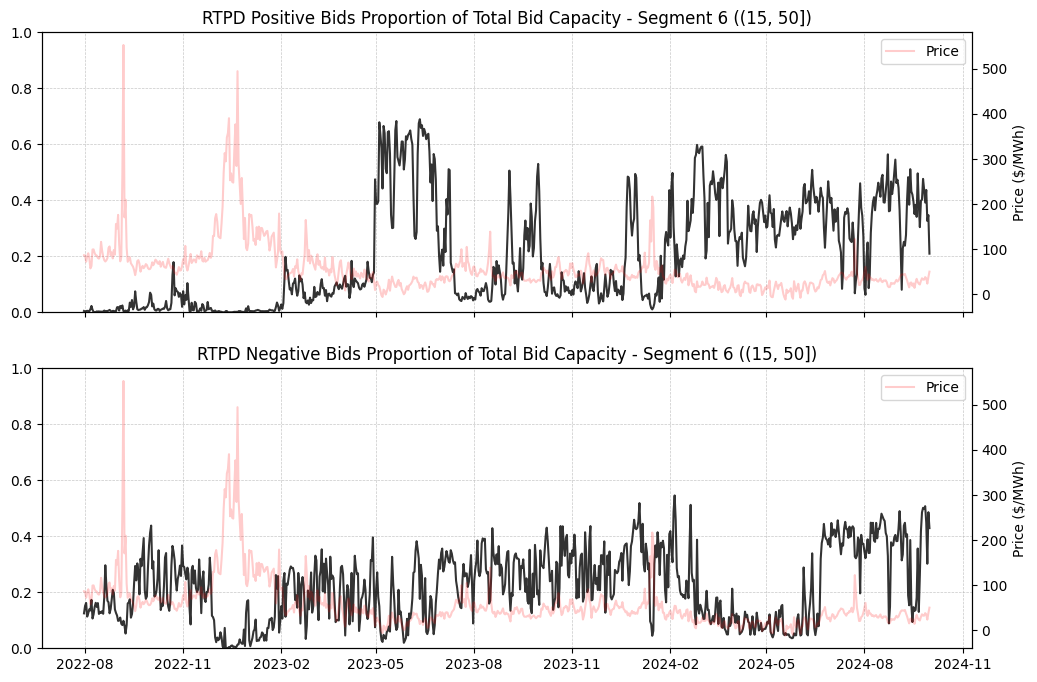

-0.00016383856356761038
7


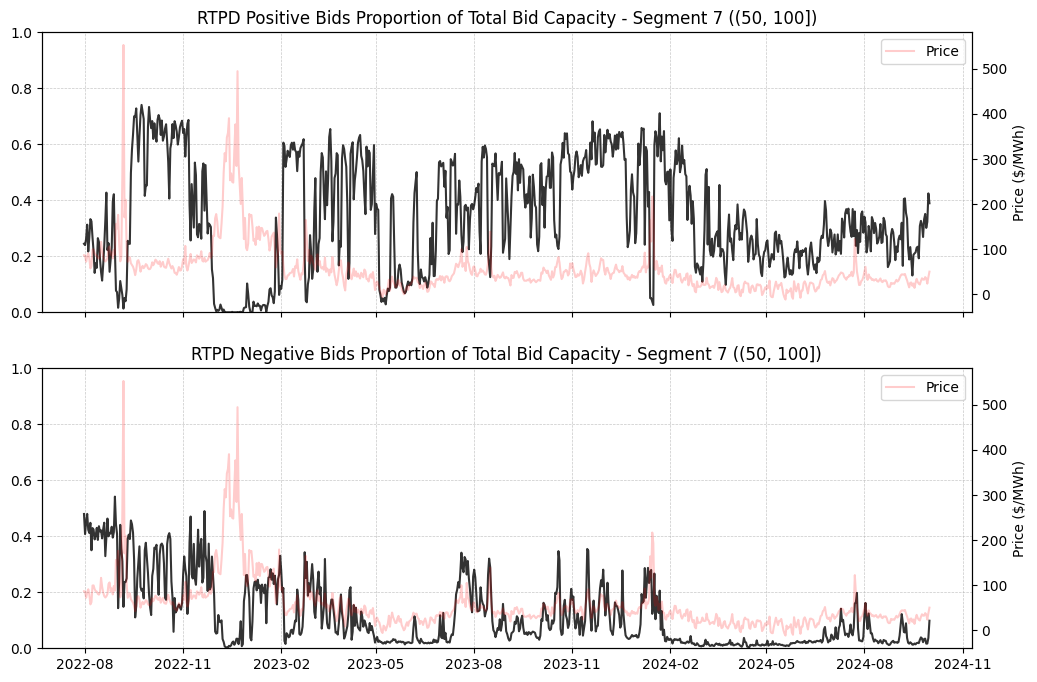

-0.002710089801750762
8


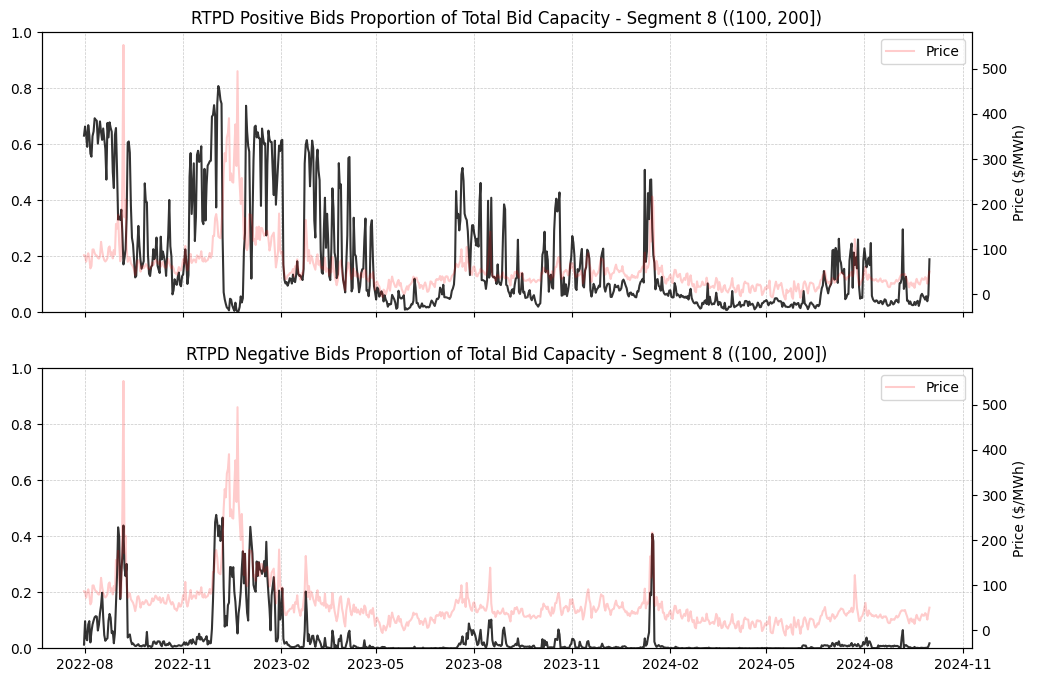

0.0
9


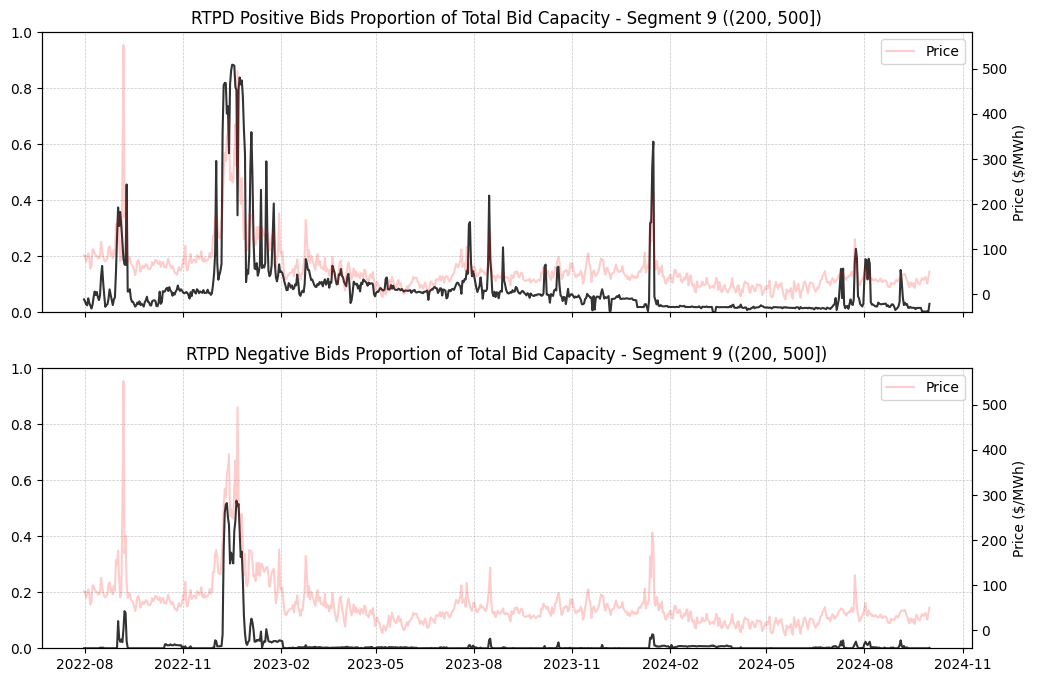

0.0
10


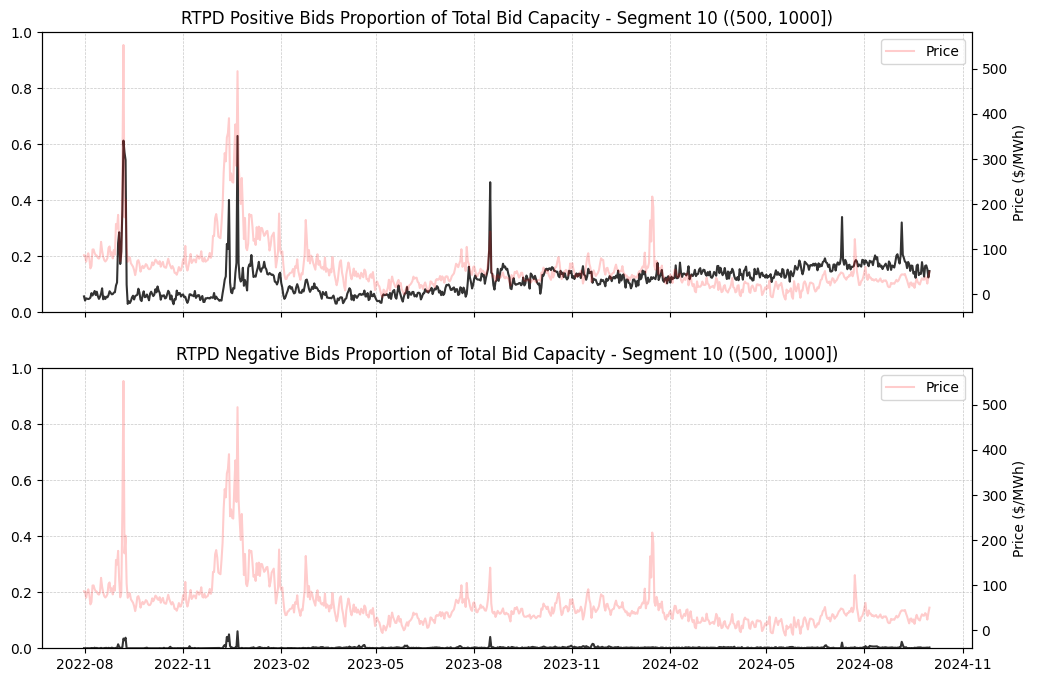

0.0
11


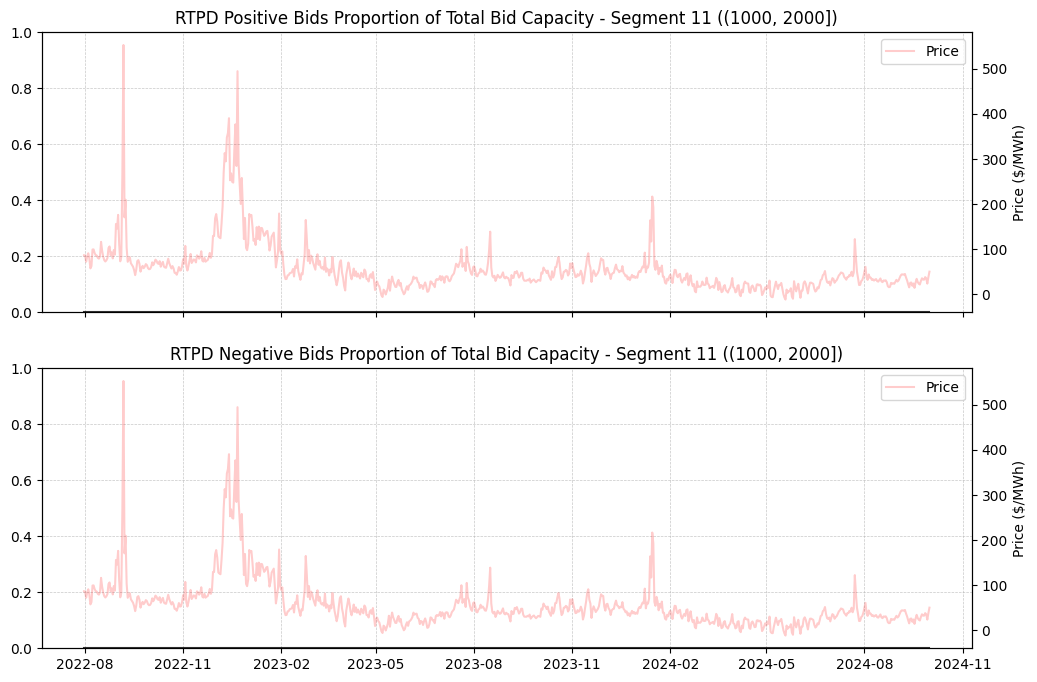

0.0


In [9]:
for interest_segment in ["ss"] + list(str(val + 1) for val in range(11)):
    print(interest_segment)
    # plot rtpd for interest segment
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot rtpd_pos_x proportions for interest segment
    for i, col in enumerate(
        [
            col
            for col in bid_columns
            if "rtpd_pos" in col and col.endswith("_" + interest_segment)
        ]
    ):
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_pos_tot"],
            label=col,
            color="black",
            alpha=0.8,
        )

    axs[0].set_title(
        f"RTPD Positive Bids Proportion of Total Bid Capacity - Segment {interest_segment} ({bid_segments[interest_segment]})"
    )
    axs[0].set_ylim(0, 1)  # Adjust y-axis

    # Create a secondary y-axis for price
    ax2_0 = axs[0].twinx()
    ax2_0.plot(
        df_daily_aggregate.index,
        df_daily_aggregate["price"],
        color="red",
        label="Price",
        alpha=0.2,
    )
    ax2_0.set_ylabel("Price ($/MWh)")
    ax2_0.legend(loc="upper right")

    # Plot rtpd_neg_x proportions for interest segment
    for i, col in enumerate(
        [
            col
            for col in bid_columns
            if "rtpd_neg" in col and col.endswith("_" + interest_segment)
        ]
    ):
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_neg_tot"],
            label=col,
            color="black",
            alpha=0.8,
        )
    axs[1].set_title(
        f"RTPD Negative Bids Proportion of Total Bid Capacity - Segment {interest_segment} ({bid_segments[interest_segment]})"
    )
    axs[1].set_ylim(0, 1)  # Adjust y-axis

    # Create a secondary y-axis for price
    ax2_1 = axs[1].twinx()
    ax2_1.plot(
        df_daily_aggregate.index,
        df_daily_aggregate["price"],
        color="red",
        label="Price",
        alpha=0.2,
    )
    ax2_1.set_ylabel("Price ($/MWh)")
    ax2_1.legend(loc="upper right")

    # Set grid lines
    for ax in axs:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    plt.show()
    print(max(df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_pos_tot"]))

ss


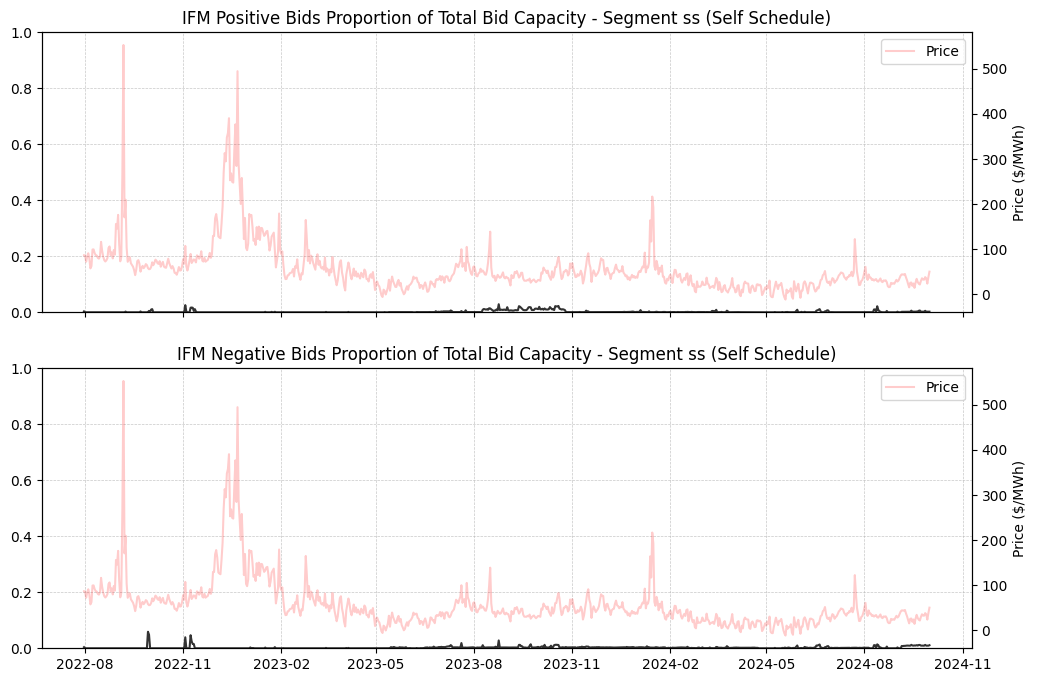

0.0
1


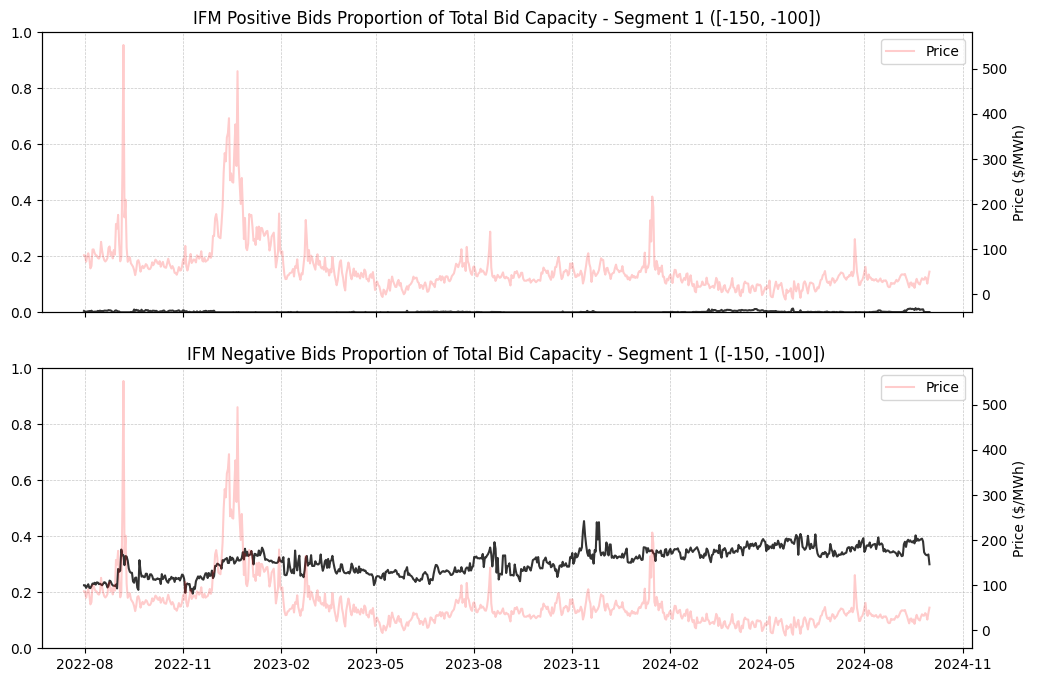

-0.185807462004804
2


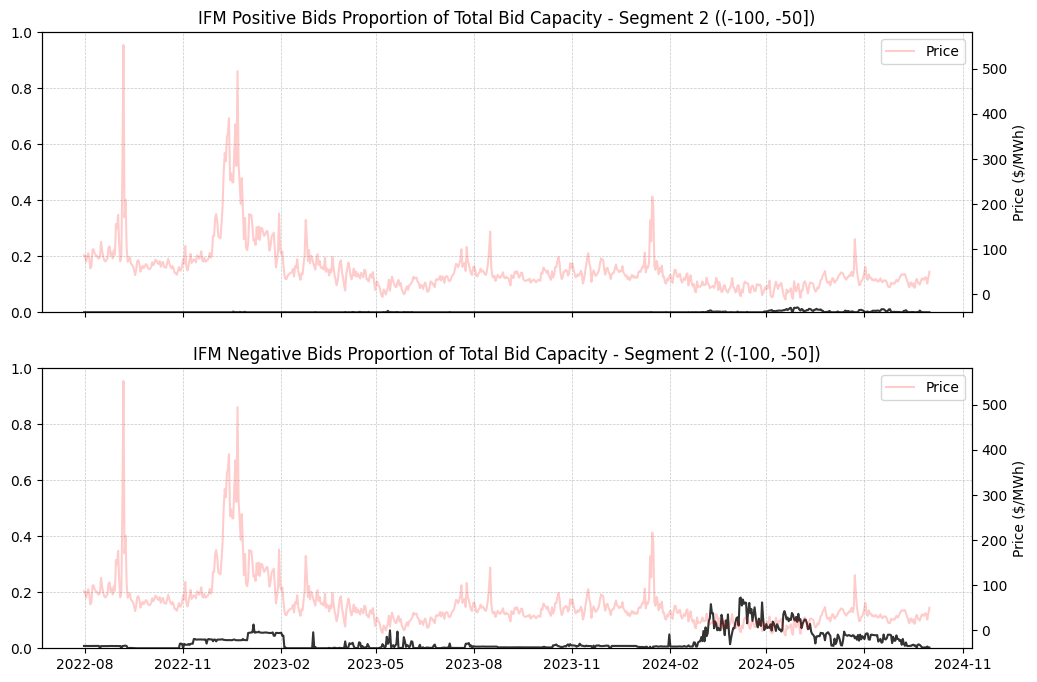

-3.6510762788697904e-06
3


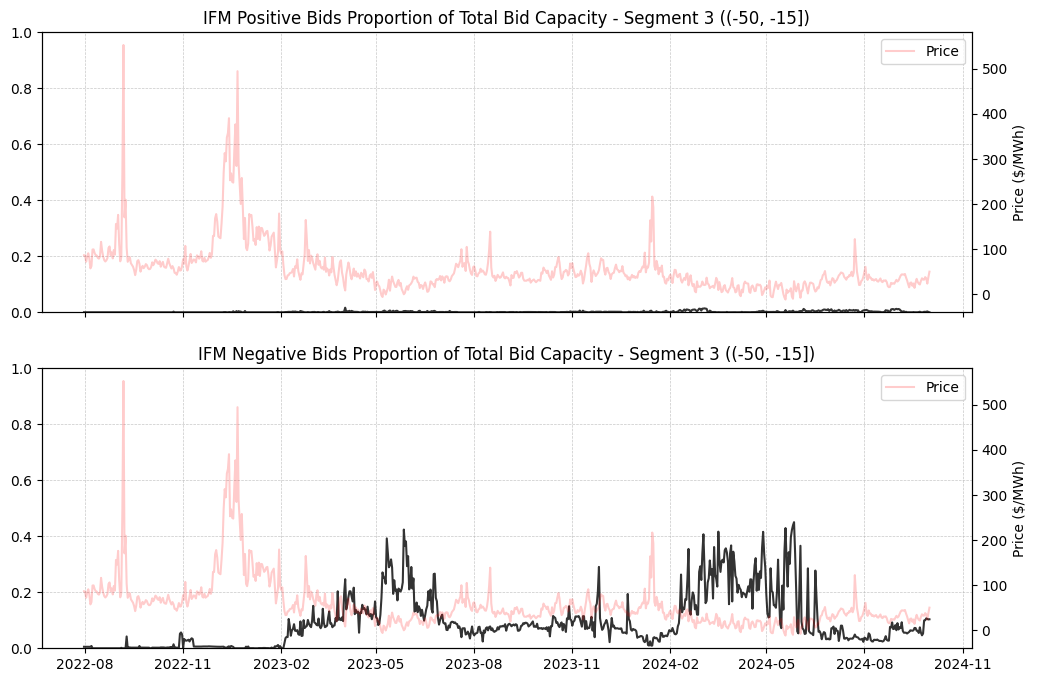

0.0
4


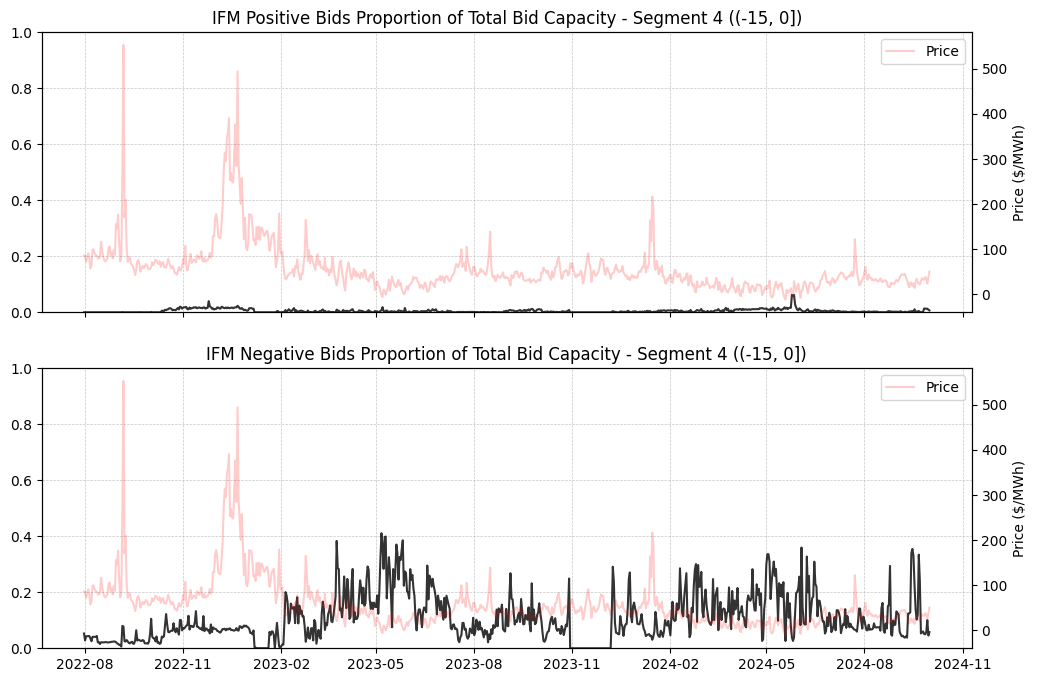

0.0
5


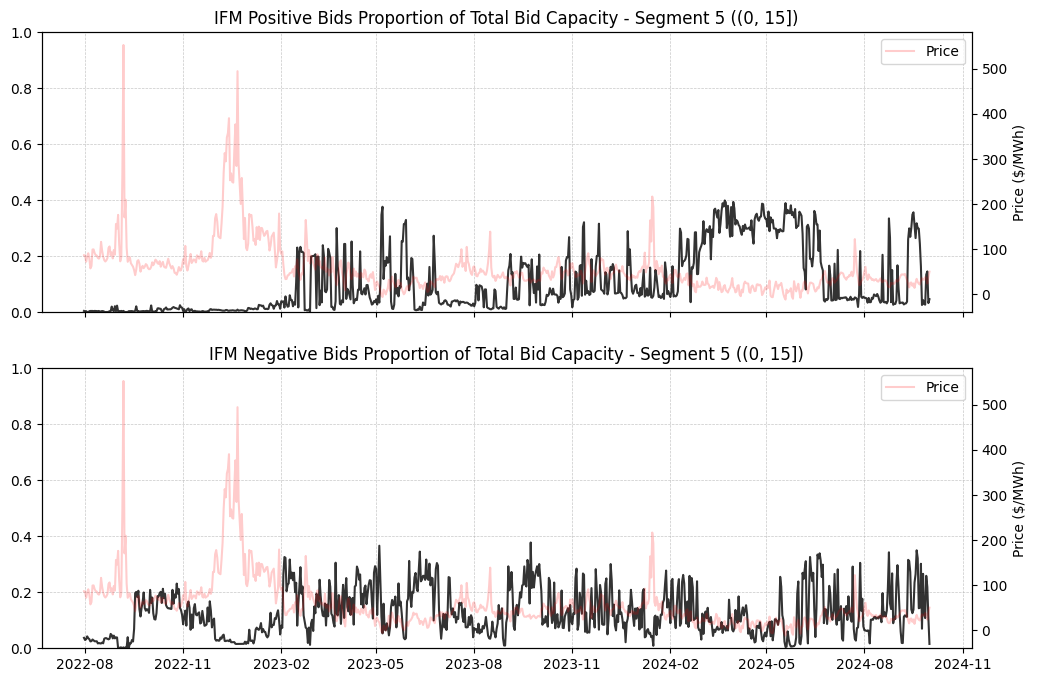

0.0
6


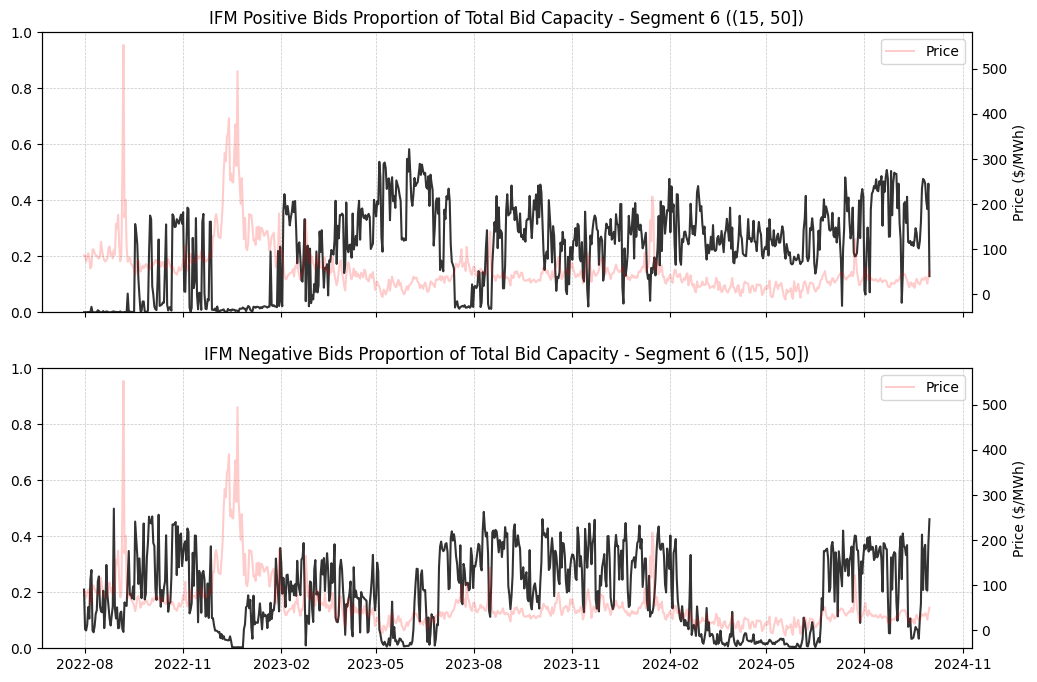

-0.0011755526740509126
7


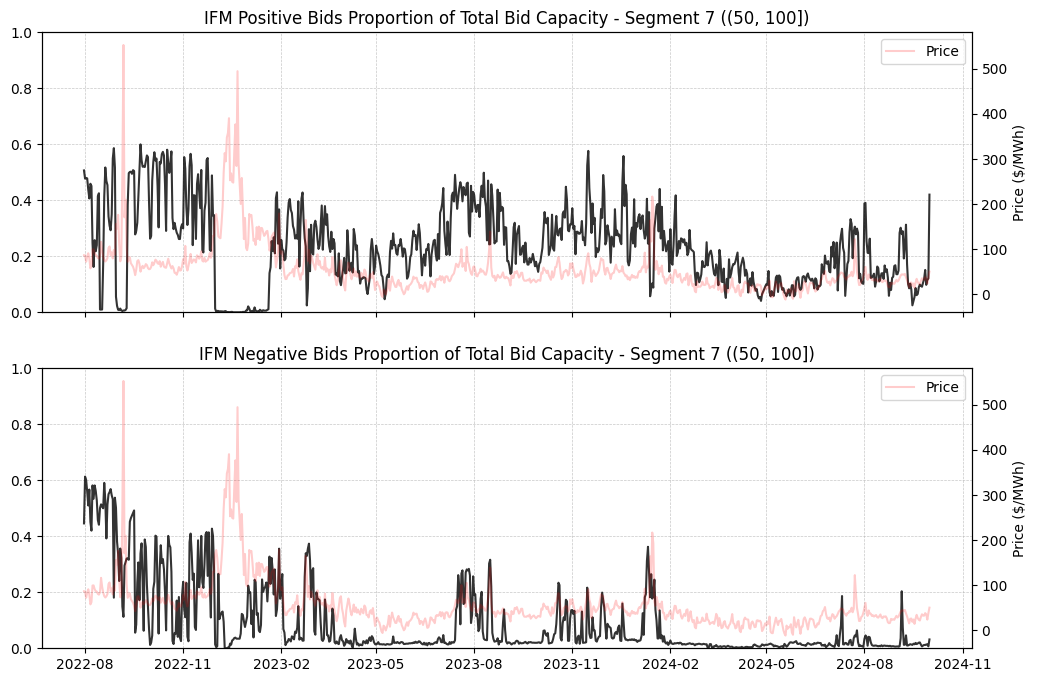

-1.1843867505970491e-05
8


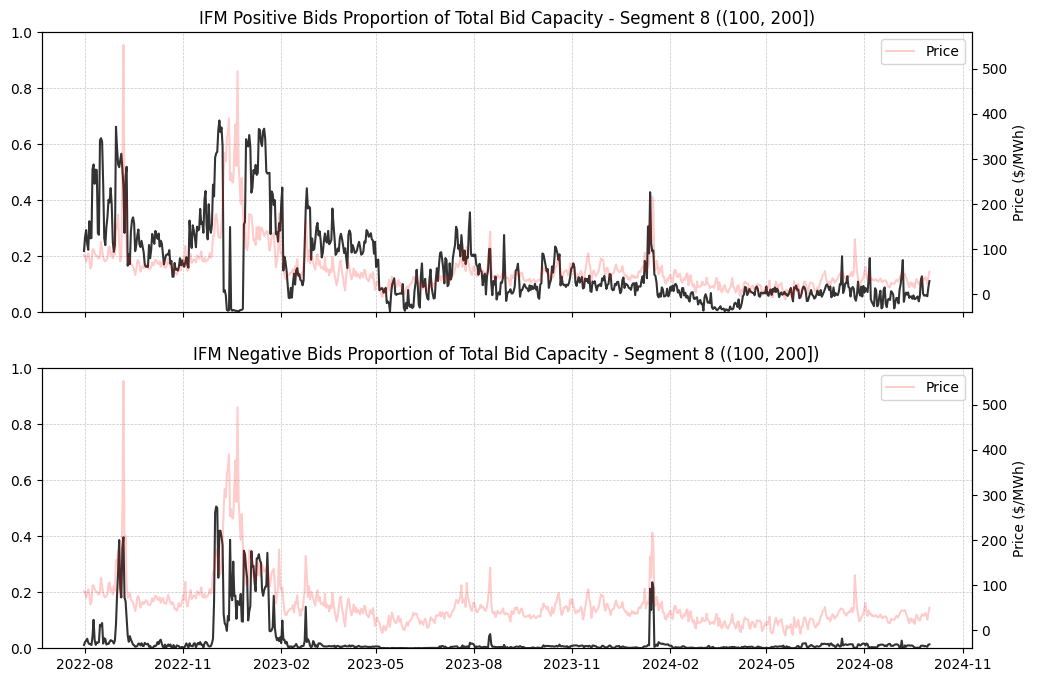

0.0
9


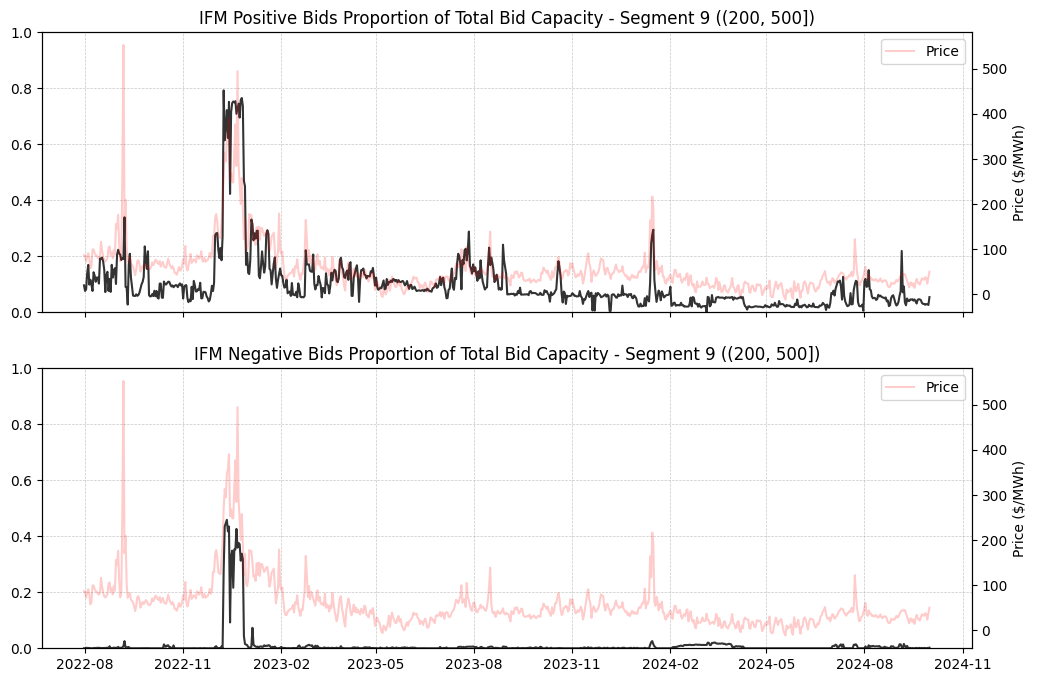

0.0
10


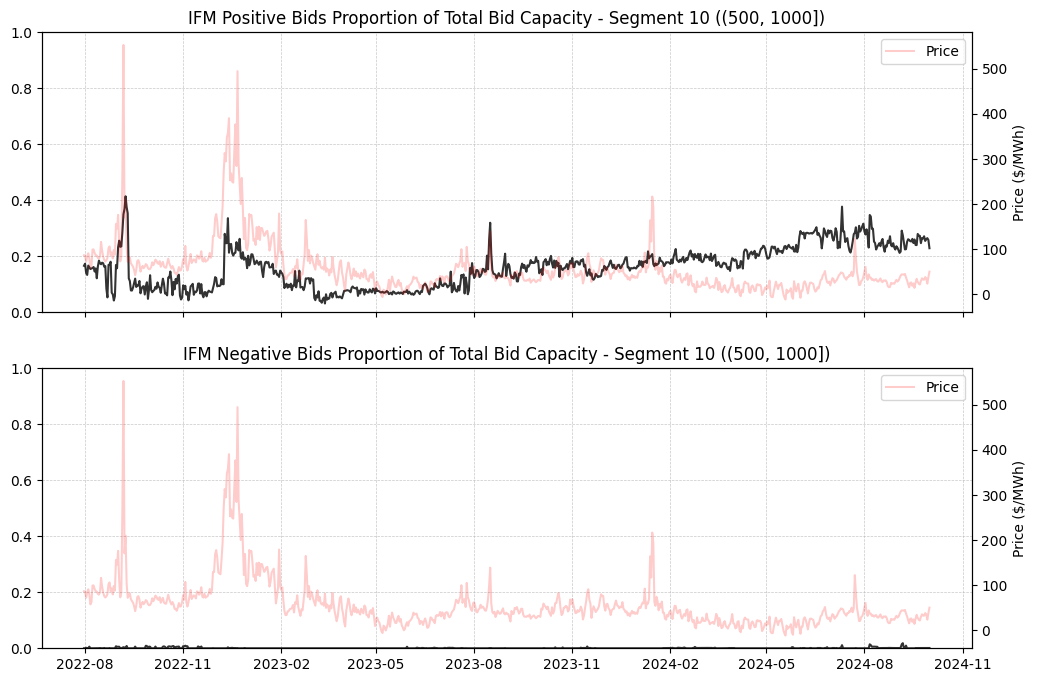

0.0
11


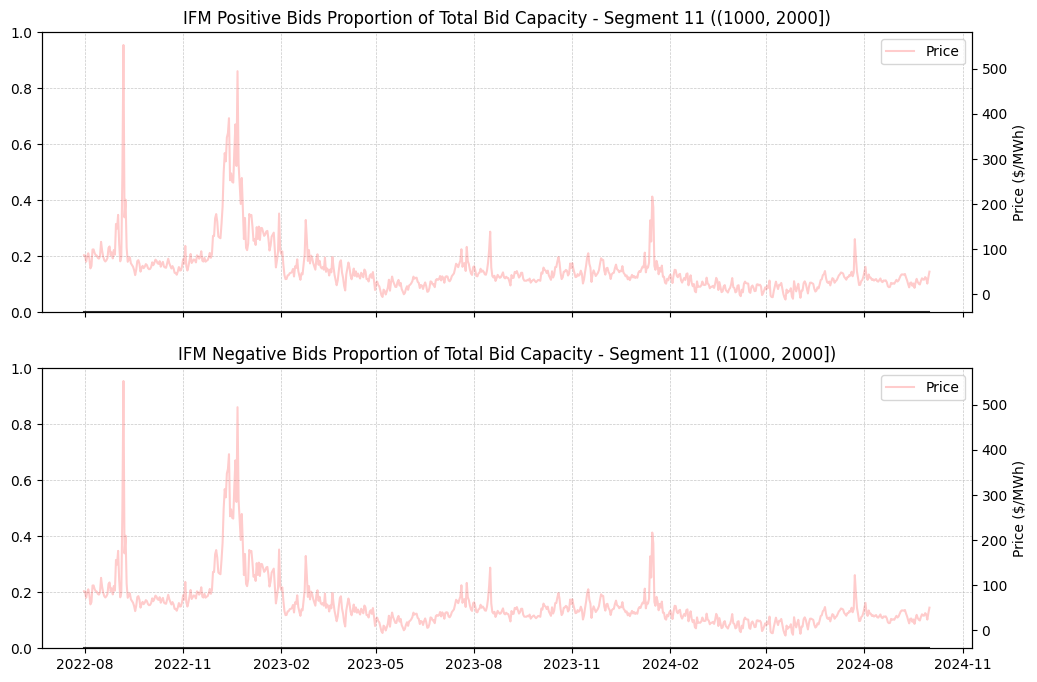

0.0


In [10]:
for interest_segment in ["ss"] + list(str(val + 1) for val in range(11)):
    print(interest_segment)
    # plot ifm for interest segment
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot ifm_pos_x proportions for interest segment
    for i, col in enumerate(
        [
            col
            for col in bid_columns
            if "ifm_pos" in col and col.endswith("_" + interest_segment)
        ]
    ):
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_pos_tot"],
            label=col,
            color="black",
            alpha=0.8,
        )

        # Create a secondary y-axis for price
        ax2_0 = axs[0].twinx()
        ax2_0.plot(
            df_daily_aggregate.index,
            df_daily_aggregate["price"],
            color="red",
            label="Price",
            alpha=0.2,
        )
        ax2_0.set_ylabel("Price ($/MWh)")
        ax2_0.legend(loc="upper right")
    axs[0].set_title(
        f"IFM Positive Bids Proportion of Total Bid Capacity - Segment {interest_segment} ({bid_segments[interest_segment]})"
    )
    axs[0].set_ylim(0, 1)  # Adjust y-axis

    # Plot ifm_neg_x proportions for interest segment
    for i, col in enumerate(
        [
            col
            for col in bid_columns
            if "ifm_neg" in col and col.endswith("_" + interest_segment)
        ]
    ):
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_neg_tot"],
            label=col,
            color="black",
            alpha=0.8,
        )
    axs[1].set_title(
        f"IFM Negative Bids Proportion of Total Bid Capacity - Segment {interest_segment} ({bid_segments[interest_segment]})"
    )

    # Create a secondary y-axis for price
    ax2_1 = axs[1].twinx()
    ax2_1.plot(
        df_daily_aggregate.index,
        df_daily_aggregate["price"],
        color="red",
        label="Price",
        alpha=0.2,
    )
    ax2_1.set_ylabel("Price ($/MWh)")
    ax2_1.legend(loc="upper right")
    axs[1].set_ylim(0, 1)  # Adjust y-axis

    # Set grid lines
    for ax in axs:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    plt.show()
    print(max(df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_pos_tot"]))

In [11]:
# Filter columns containing '11'
bid_11_columns = [col for col in df.columns if "11" in col]

# Calculate the sum for each of these columns
bid_11_sums = df[bid_11_columns].sum()

# Print the sums
print(bid_11_sums)

bid_ifm_pos_11     0.0
bid_ifm_neg_11     0.0
bid_rtpd_pos_11    0.0
bid_rtpd_neg_11    0.0
dtype: float64


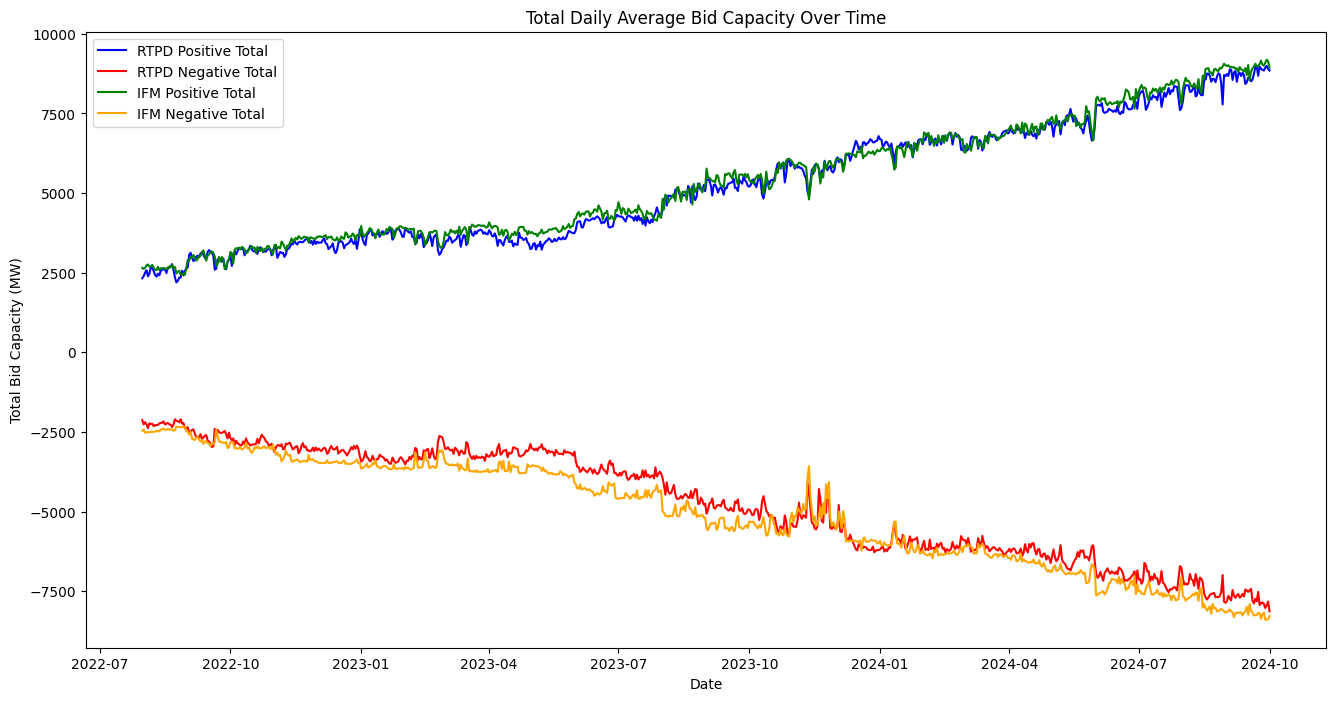

In [12]:
# Plot total bid capacity over time for both positive and negative RTPD and IFM bids
fig, ax = plt.subplots(figsize=(16, 8))

# Plot RTPD positive and negative total bid capacity
ax.plot(
    df_daily_aggregate.index,
    df_daily_aggregate["bid_rtpd_pos_tot"],
    label="RTPD Positive Total",
    color="blue",
)
ax.plot(
    df_daily_aggregate.index,
    df_daily_aggregate["bid_rtpd_neg_tot"],
    label="RTPD Negative Total",
    color="red",
)

# Plot IFM positive and negative total bid capacity
ax.plot(
    df_daily_aggregate.index,
    df_daily_aggregate["bid_ifm_pos_tot"],
    label="IFM Positive Total",
    color="green",
)
ax.plot(
    df_daily_aggregate.index,
    df_daily_aggregate["bid_ifm_neg_tot"],
    label="IFM Negative Total",
    color="orange",
)

# Set title and labels
ax.set_title("Total Daily Average Bid Capacity Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Total Bid Capacity (MW)")

# Add legend
ax.legend(loc="upper left")

plt.show()

In [13]:
print(
    df_daily_aggregate["bid_ifm_pos_tot"][0], df_daily_aggregate["bid_ifm_pos_tot"][-1]
)

2652.240416666667 8935.8875


C:\Users\Astro\AppData\Local\Temp\ipykernel_31616\3844608432.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_daily_aggregate["bid_ifm_pos_tot"][0], df_daily_aggregate["bid_ifm_pos_tot"][-1]


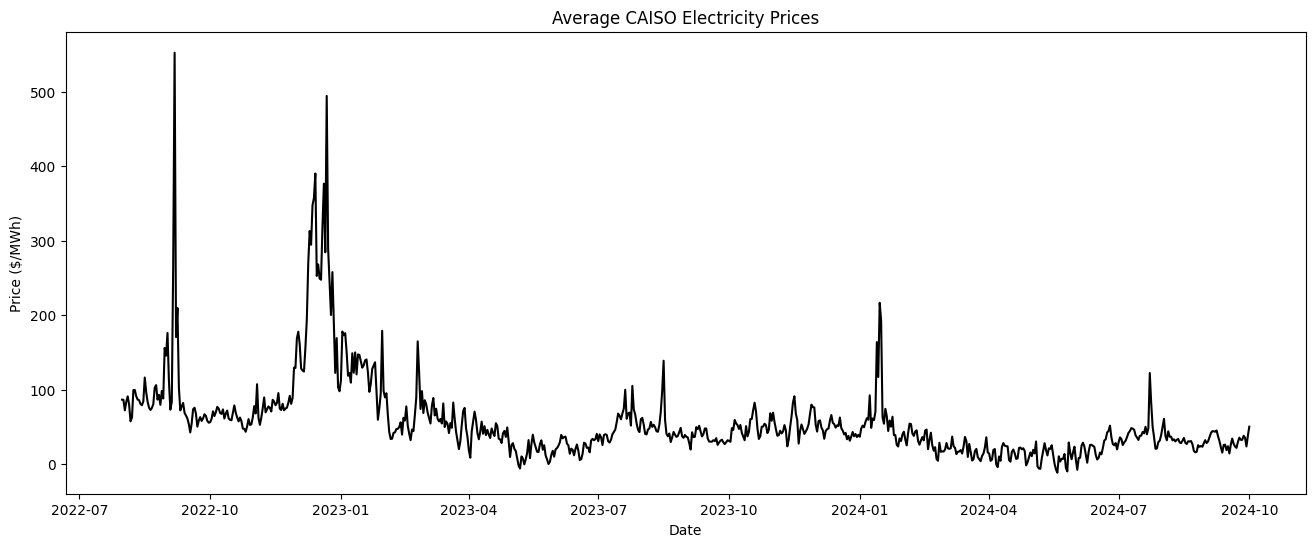

In [14]:
# Plot total bid capacity over time for both positive and negative RTPD and IFM bids
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(
    df_daily_aggregate.index,
    df_daily_aggregate["price"],
    label="Average CAISO Price",
    color="black",
)
ax.set_xlabel("Date")
ax.set_ylabel("Price ($/MWh)")
ax.set_title("Average CAISO Electricity Prices")

plt.show()

In [32]:
# identify dates, price spikes, and average prices
start_filter_date = pd.Timestamp("2024-07-01")
end_filter_date = pd.Timestamp("2024-10-01")

df_filtered = df_daily_aggregate[
    (df_daily_aggregate.index > start_filter_date)
    & (df_daily_aggregate.index < end_filter_date)
]
print(df_filtered.index[np.argmax(df_filtered.price)])
print(df_filtered.price[np.argmax(df_filtered.price)])
print(np.mean(df_filtered.price))

2024-07-23 00:00:00
122.47371691071429
34.86647530595227


C:\Users\Astro\AppData\Local\Temp\ipykernel_31616\3339174790.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_filtered.price[np.argmax(df_filtered.price)])


In [16]:
def plot_bid_distribution(
    start_date: str = None,
    end_date: str = None,
):
    if end_date == None:
        # Filter the data for the start_date
        df_interest_date = df_daily_aggregate.loc[pd.Timestamp(start_date)]
        date_interest_string = start_date
    else:
        # Filter the data for the date range
        df_interest_date = df_daily_aggregate.loc[
            pd.Timestamp(start_date) : pd.Timestamp(end_date)
        ]
        date_interest_string = f"{start_date} to {end_date}"

        df_interest_date = df_interest_date.mean()

    # Extract the relevant columns and align segments by suffix
    suffixes = ["ss"] + [str(i) for i in range(1, 12)]
    x_markers = [bid_segments[s] for s in suffixes]

    rtpd_pos_columns = [f"bid_rtpd_pos_{suffix}" for suffix in suffixes]
    rtpd_neg_columns = [f"bid_rtpd_neg_{suffix}" for suffix in suffixes]
    ifm_pos_columns = [f"bid_ifm_pos_{suffix}" for suffix in suffixes]
    ifm_neg_columns = [f"bid_ifm_neg_{suffix}" for suffix in suffixes]

    max_y_lim = max(
        max(df_interest_date[rtpd_pos_columns] / df_interest_date["bid_rtpd_pos_tot"]),
        max(df_interest_date[ifm_pos_columns] / df_interest_date["bid_ifm_pos_tot"]),
        max(df_interest_date[rtpd_neg_columns] / df_interest_date["bid_rtpd_neg_tot"]),
        max(df_interest_date[ifm_neg_columns] / df_interest_date["bid_ifm_neg_tot"]),
    )
    max_y_lim = math.ceil(max_y_lim * 10) / 10

    # Create a 2x2 figure
    fig, axs = plt.subplots(
        2, 2, figsize=(12, 8), sharex=True, sharey=False, gridspec_kw={"hspace": 0}
    )

    # Plot the stacked distribution for RTPD positive bids
    (df_interest_date[rtpd_pos_columns] / df_interest_date["bid_rtpd_pos_tot"]).plot(
        kind="bar", stacked=True, ax=axs[0, 0], width=1.0
    )
    axs[0, 0].set_xlabel("Bid Segments")
    axs[0, 0].set_ylabel("Positive Bid Seg. Prop.")
    axs[0, 0].set_ylim((0, max_y_lim))
    axs[0, 0].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)
    axs[0, 0].grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)

    # Plot the stacked distribution for IFM positive bids
    (df_interest_date[ifm_pos_columns] / df_interest_date["bid_ifm_pos_tot"]).plot(
        kind="bar", stacked=True, ax=axs[0, 1], width=1.0
    )
    axs[0, 1].set_ylim((0, max_y_lim))
    axs[0, 1].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)
    axs[0, 1].grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)

    # Plot the stacked distribution for RTPD negative bids
    (df_interest_date[rtpd_neg_columns] / df_interest_date["bid_rtpd_neg_tot"]).plot(
        kind="bar", stacked=True, ax=axs[1, 0], width=1.0
    )
    axs[1, 0].set_xlabel("RTPD Bid Segments")
    axs[1, 0].set_ylabel("Negative Bid Seg. Prop.")
    axs[1, 0].invert_yaxis()
    axs[1, 0].set_ylim((max_y_lim, 0))
    axs[1, 0].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)
    axs[1, 0].grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)

    # Plot the stacked distribution for IFM negative bids
    (df_interest_date[ifm_neg_columns] / df_interest_date["bid_ifm_neg_tot"]).plot(
        kind="bar", stacked=True, ax=axs[1, 1], width=1.0
    )
    axs[1, 1].set_xlabel("IFM Bid Segments")
    axs[1, 1].invert_yaxis()
    axs[1, 1].set_ylim((max_y_lim, 0))
    axs[1, 1].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)
    axs[1, 1].grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)

    fig.suptitle(f"RTPD and IFM Bid Segment Composition for {date_interest_string}")
    plt.xticks(np.arange(0, 12), x_markers)

    plt.tight_layout()
    plt.show()

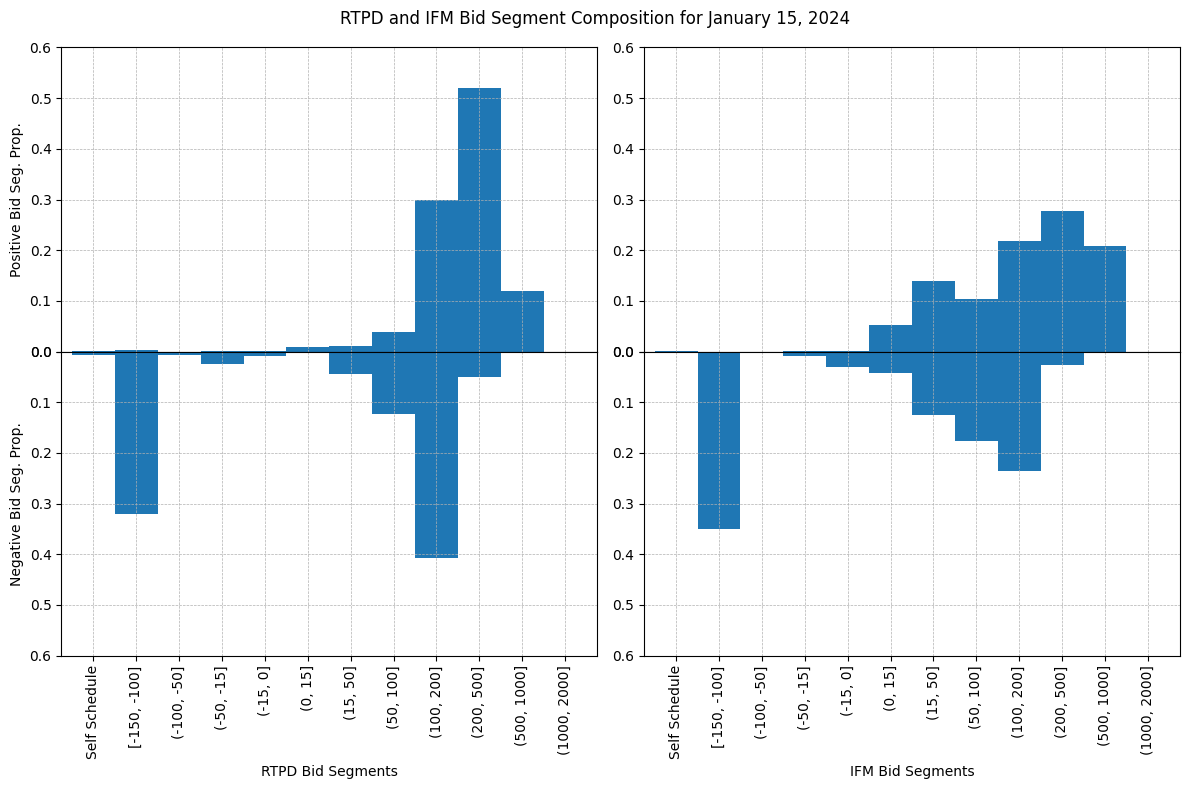

In [17]:
plot_bid_distribution(start_date="January 15, 2024")

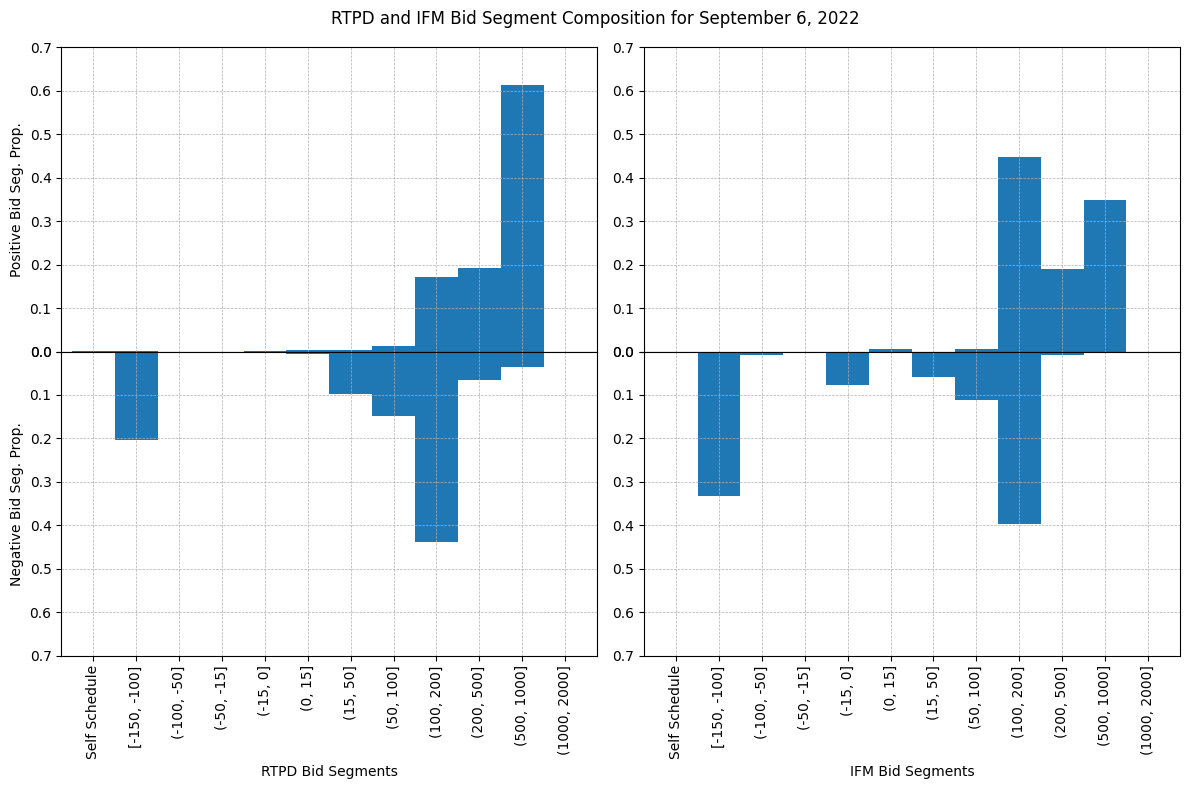

In [18]:
plot_bid_distribution(start_date="September 6, 2022")

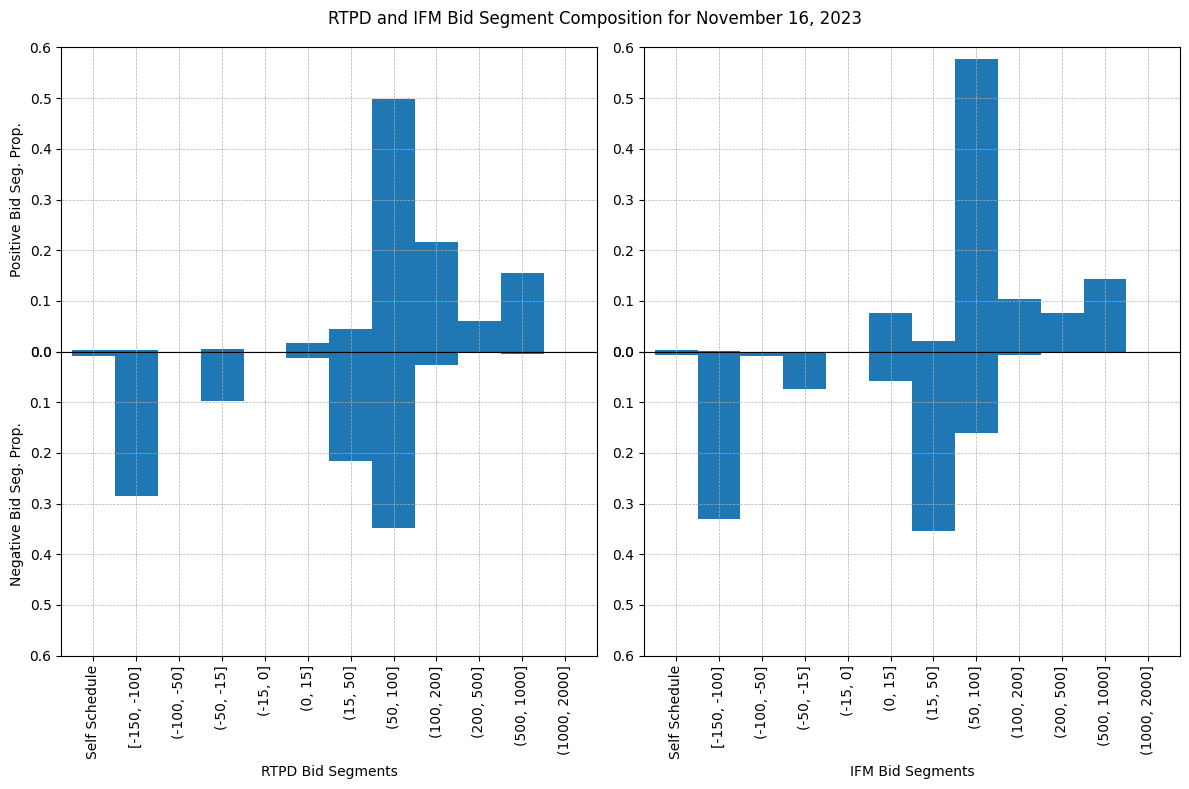

In [19]:
plot_bid_distribution(start_date="November 16, 2023")

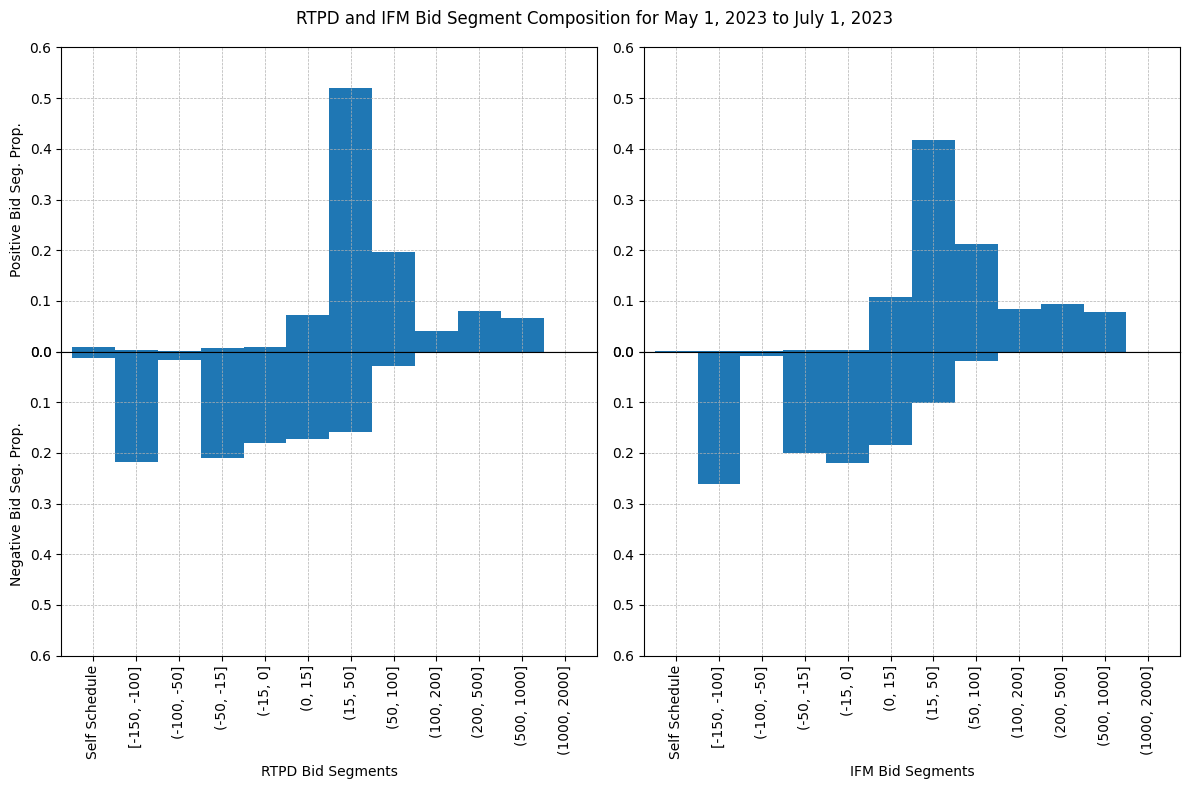

In [20]:
plot_bid_distribution(start_date="May 1, 2023", end_date="July 1, 2023")

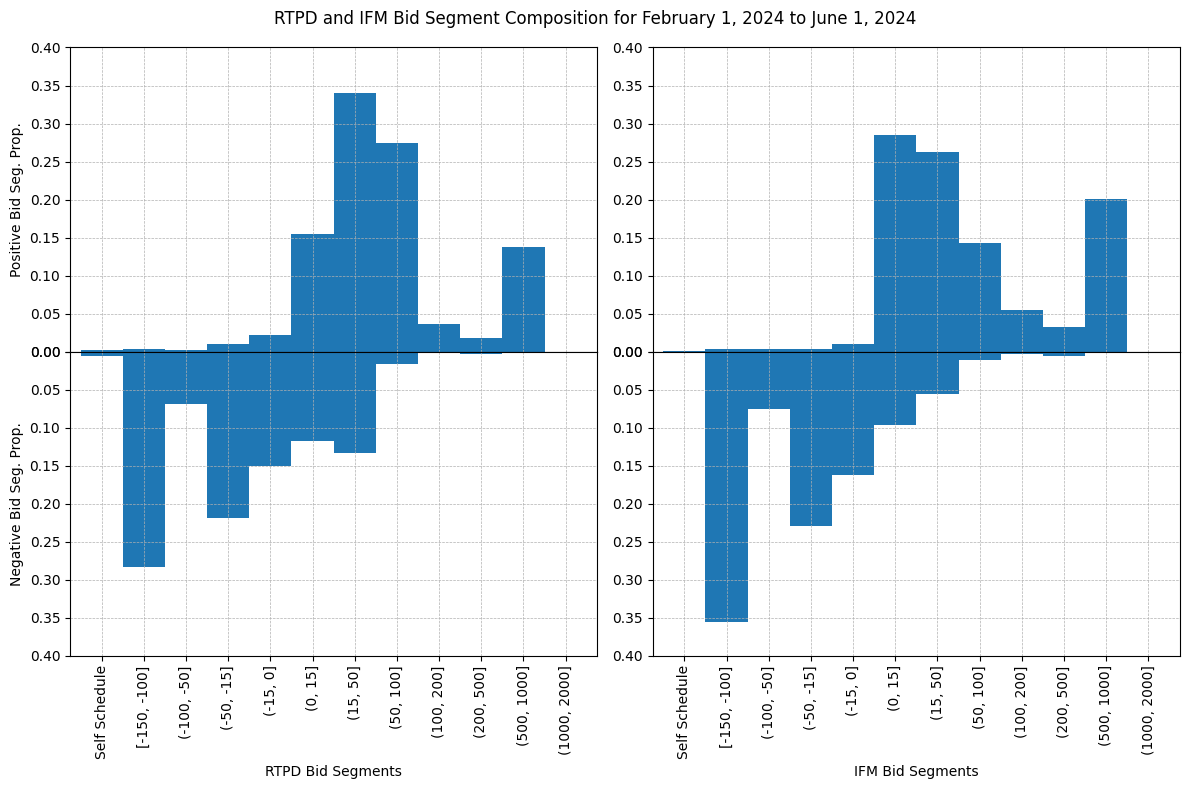

In [21]:
plot_bid_distribution(start_date="February 1, 2024", end_date="June 1, 2024")

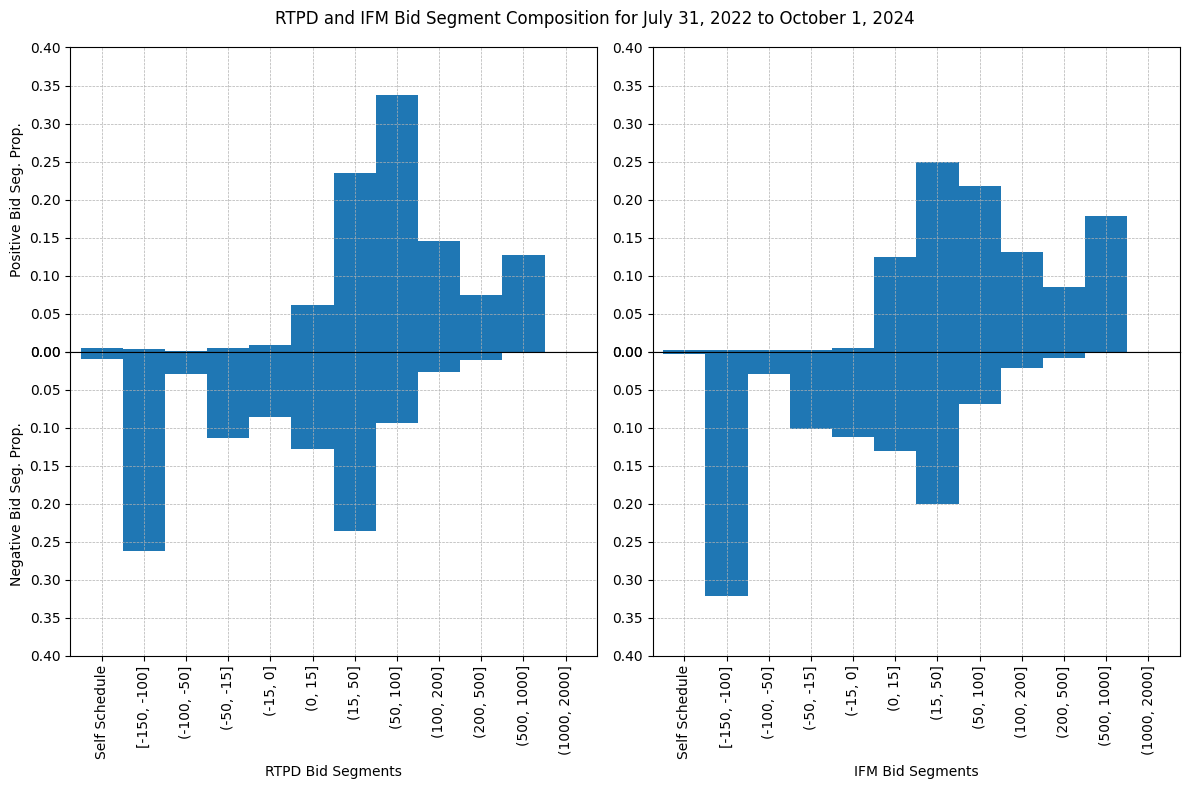

In [22]:
plot_bid_distribution(start_date="July 31, 2022", end_date="October 1, 2024")

In [23]:
bid_segment_edges = [-150, -100, -50, -15, 0, 15, 50, 100, 200, 500, 1000, 2000]
bid_segment_weights = [
    (bid_segment_edges[i] + bid_segment_edges[i + 1]) / 2.0
    for i in range(len(bid_segment_edges) - 1)
]
# bid_segment_weights = [1.] * 11

df_weighted_daily = df_daily_aggregate.copy()
df_weighted_daily["bid_ifm_pos_avg"] = (
    df_weighted_daily["bid_ifm_pos_1"] * bid_segment_weights[0]
    + df_weighted_daily["bid_ifm_pos_2"] * bid_segment_weights[1]
    + df_weighted_daily["bid_ifm_pos_3"] * bid_segment_weights[2]
    + df_weighted_daily["bid_ifm_pos_4"] * bid_segment_weights[3]
    + df_weighted_daily["bid_ifm_pos_5"] * bid_segment_weights[4]
    + df_weighted_daily["bid_ifm_pos_6"] * bid_segment_weights[5]
    + df_weighted_daily["bid_ifm_pos_7"] * bid_segment_weights[6]
    + df_weighted_daily["bid_ifm_pos_8"] * bid_segment_weights[7]
    + df_weighted_daily["bid_ifm_pos_9"] * bid_segment_weights[8]
    + df_weighted_daily["bid_ifm_pos_10"] * bid_segment_weights[9]
    + df_weighted_daily["bid_ifm_pos_11"] * bid_segment_weights[10]
) / df_weighted_daily["bid_ifm_pos_tot"]


df_weighted_daily["bid_ifm_neg_avg"] = (
    df_weighted_daily["bid_ifm_neg_1"] * bid_segment_weights[0]
    + df_weighted_daily["bid_ifm_neg_2"] * bid_segment_weights[1]
    + df_weighted_daily["bid_ifm_neg_3"] * bid_segment_weights[2]
    + df_weighted_daily["bid_ifm_neg_4"] * bid_segment_weights[3]
    + df_weighted_daily["bid_ifm_neg_5"] * bid_segment_weights[4]
    + df_weighted_daily["bid_ifm_neg_6"] * bid_segment_weights[5]
    + df_weighted_daily["bid_ifm_neg_7"] * bid_segment_weights[6]
    + df_weighted_daily["bid_ifm_neg_8"] * bid_segment_weights[7]
    + df_weighted_daily["bid_ifm_neg_9"] * bid_segment_weights[8]
    + df_weighted_daily["bid_ifm_neg_10"] * bid_segment_weights[9]
    + df_weighted_daily["bid_ifm_neg_11"] * bid_segment_weights[10]
) / df_weighted_daily["bid_ifm_neg_tot"]

df_weighted_daily["bid_rtpd_pos_avg"] = (
    df_weighted_daily["bid_rtpd_pos_1"] * bid_segment_weights[0]
    + df_weighted_daily["bid_rtpd_pos_2"] * bid_segment_weights[1]
    + df_weighted_daily["bid_rtpd_pos_3"] * bid_segment_weights[2]
    + df_weighted_daily["bid_rtpd_pos_4"] * bid_segment_weights[3]
    + df_weighted_daily["bid_rtpd_pos_5"] * bid_segment_weights[4]
    + df_weighted_daily["bid_rtpd_pos_6"] * bid_segment_weights[5]
    + df_weighted_daily["bid_rtpd_pos_7"] * bid_segment_weights[6]
    + df_weighted_daily["bid_rtpd_pos_8"] * bid_segment_weights[7]
    + df_weighted_daily["bid_rtpd_pos_9"] * bid_segment_weights[8]
    + df_weighted_daily["bid_rtpd_pos_10"] * bid_segment_weights[9]
    + df_weighted_daily["bid_rtpd_pos_11"] * bid_segment_weights[10]
) / df_weighted_daily["bid_rtpd_pos_tot"]

df_weighted_daily["bid_rtpd_neg_avg"] = (
    df_weighted_daily["bid_rtpd_neg_1"] * bid_segment_weights[0]
    + df_weighted_daily["bid_rtpd_neg_2"] * bid_segment_weights[1]
    + df_weighted_daily["bid_rtpd_neg_3"] * bid_segment_weights[2]
    + df_weighted_daily["bid_rtpd_neg_4"] * bid_segment_weights[3]
    + df_weighted_daily["bid_rtpd_neg_5"] * bid_segment_weights[4]
    + df_weighted_daily["bid_rtpd_neg_6"] * bid_segment_weights[5]
    + df_weighted_daily["bid_rtpd_neg_7"] * bid_segment_weights[6]
    + df_weighted_daily["bid_rtpd_neg_8"] * bid_segment_weights[7]
    + df_weighted_daily["bid_rtpd_neg_9"] * bid_segment_weights[8]
    + df_weighted_daily["bid_rtpd_neg_10"] * bid_segment_weights[9]
    + df_weighted_daily["bid_rtpd_neg_11"] * bid_segment_weights[10]
) / df_weighted_daily["bid_rtpd_neg_tot"]

In [24]:
df_weighted_daily

bid_ifm_pos_ss  bid_ifm_pos_1  bid_ifm_pos_2  bid_ifm_pos_3  \
datetime                                                                  
2022-07-31        8.333333      12.500000            0.0       0.000000   
2022-08-01        0.000000       5.583333            0.0       0.000000   
2022-08-02        0.000000       0.833333            0.0       0.000000   
2022-08-03        0.000000       8.833333            0.0       0.000000   
2022-08-04        0.000000       5.166667            0.0       0.000000   
...                    ...            ...            ...            ...   
2024-09-27       47.541667       6.333333            0.0      12.155417   
2024-09-28       19.541667       6.333333            0.0      17.076667   
2024-09-29       19.541667       6.333333            0.0      28.337083   
2024-09-30       19.541667       6.458333            0.0      10.903333   
2024-10-01       19.541667       6.458333            0.0       0.000000   

            bid_ifm_pos_4  bid_ifm_pos_5  bid_ifm_pos_6  bid_ifm_pos_7  \
datetime                                                                 
2022-07-31       0.000000      12.500417       0.315000    1343.541667   
2022-08-01       0.000000       5.410000       0.041667    1251.666667   
2022-08-02       0.000000      10.346667       0.041667    1273.000000   
2022-08-03       0.000000       3.125000       1.250000    1308.666667   
2022-08-04       0.000000       0.000000       2.687500    1207.291667   
...                   ...            ...            ...            ...   
2024-09-27     119.393750     245.937500    4137.208333    1360.591667   
2024-09-28     112.918750    1223.500000    3621.708333     891.262500   
2024-09-29     118.989583    1340.750000    3384.833333    1061.645833   
2024-09-30      83.001667     300.325000    4195.916667    1101.708333   
2024-10-01      59.704167     417.245833    1153.929167    3754.708333   

            bid_ifm_pos_8  bid_ifm_pos_9  ...  bid_rtpd_neg_11      price  \
datetime                                  ...                               
2022-07-31     579.845833     254.862500  ...              0.0  86.716314   
2022-08-01     704.900000     200.037500  ...              0.0  86.421258   
2022-08-02     778.637500     217.254167  ...              0.0  72.452629   
2022-08-03     669.116667     380.441667  ...              0.0  83.897477   
2022-08-04     615.162500     466.616667  ...              0.0  91.197719   
...                   ...            ...  ...              ...        ...   
2024-09-27     536.904167     241.035417  ...              0.0  38.292945   
2024-09-28     560.419167     263.758333  ...              0.0  35.687148   
2024-09-29     526.070833     266.556250  ...              0.0  23.966624   
2024-09-30     819.260833     238.285417  ...              0.0  38.224384   
2024-10-01     995.216667     484.416667  ...              0.0  50.449650   

            bid_rtpd_neg_tot  bid_rtpd_pos_tot  bid_ifm_neg_tot  \
datetime                                                          
2022-07-31      -2126.098229       2327.148750     -2458.290417   
2022-08-01      -2260.615104       2390.197917     -2421.708750   
2022-08-02      -2190.021042       2507.009063     -2522.553333   
2022-08-03      -2262.262917       2576.544583     -2508.805000   
2022-08-04      -2381.238750       2386.981250     -2504.426250   
...                      ...               ...              ...   
2024-09-27      -7897.778542       8846.215000     -8172.764583   
2024-09-28      -8023.951771       8938.120417     -8392.428333   
2024-09-29      -7934.661042       8990.361042     -8388.011667   
2024-09-30      -7824.261146       8892.000833     -8378.409583   
2024-10-01      -8124.833021       8847.558125     -8279.919583   

            bid_ifm_pos_tot  bid_ifm_pos_avg  bid_ifm_neg_avg  \
datetime                                                        
2022-07-31      2652.240417       228.388841        12.969736   
2022

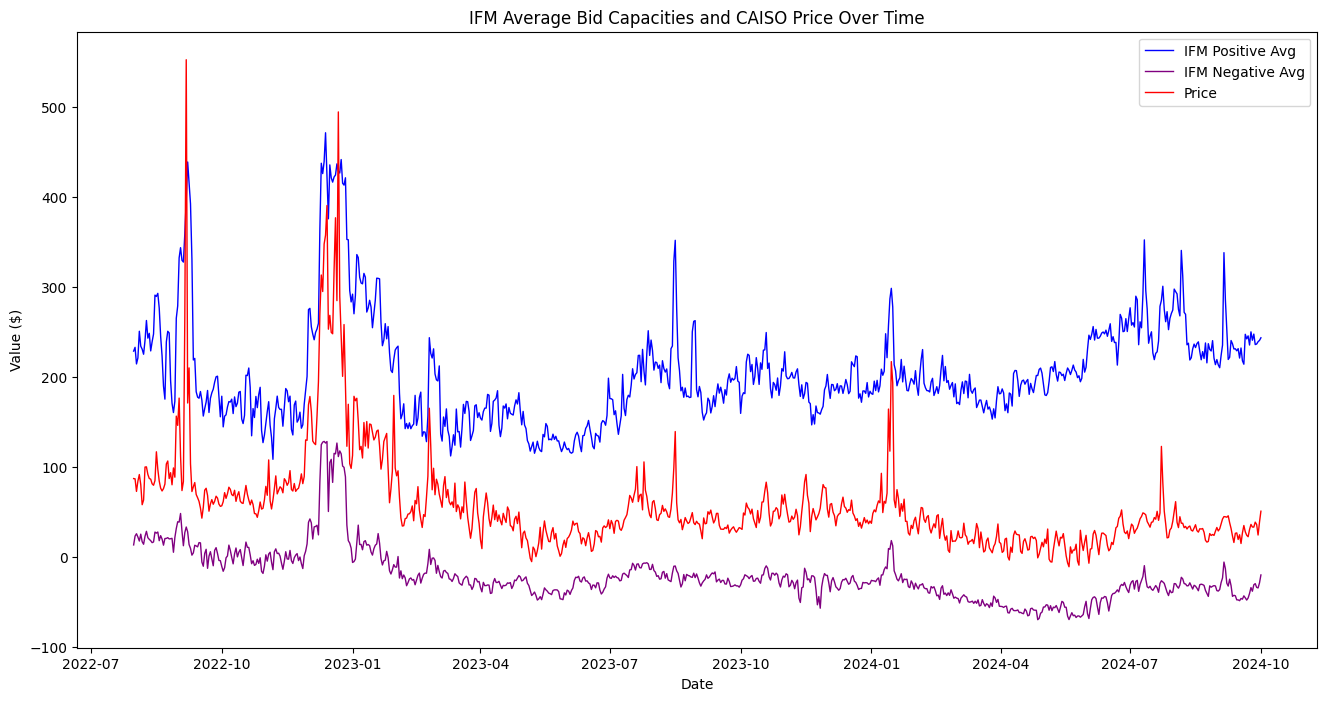

In [25]:
# Plot IFM average bid capacities and price
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot IFM positive and negative average bid capacities
ax1.plot(
    df_weighted_daily.index,
    df_weighted_daily["bid_ifm_pos_avg"],
    label="IFM Positive Avg",
    color="blue",
    linewidth=1,
)
ax1.plot(
    df_weighted_daily.index,
    df_weighted_daily["bid_ifm_neg_avg"],
    label="IFM Negative Avg",
    color="purple",
    linewidth=1,
)

# Plot price
ax1.plot(
    df_weighted_daily.index,
    df_weighted_daily["price"],
    label="Price",
    color="red",
    linewidth=1,
    alpha=1,
)

# Set title and labels for the y-axis
ax1.set_title("IFM Average Bid Capacities and CAISO Price Over Time")
ax1.set_xlabel("Date")
ax1.set_ylabel("Value ($)")

# Add legend
ax1.legend(loc="upper right")

plt.show()

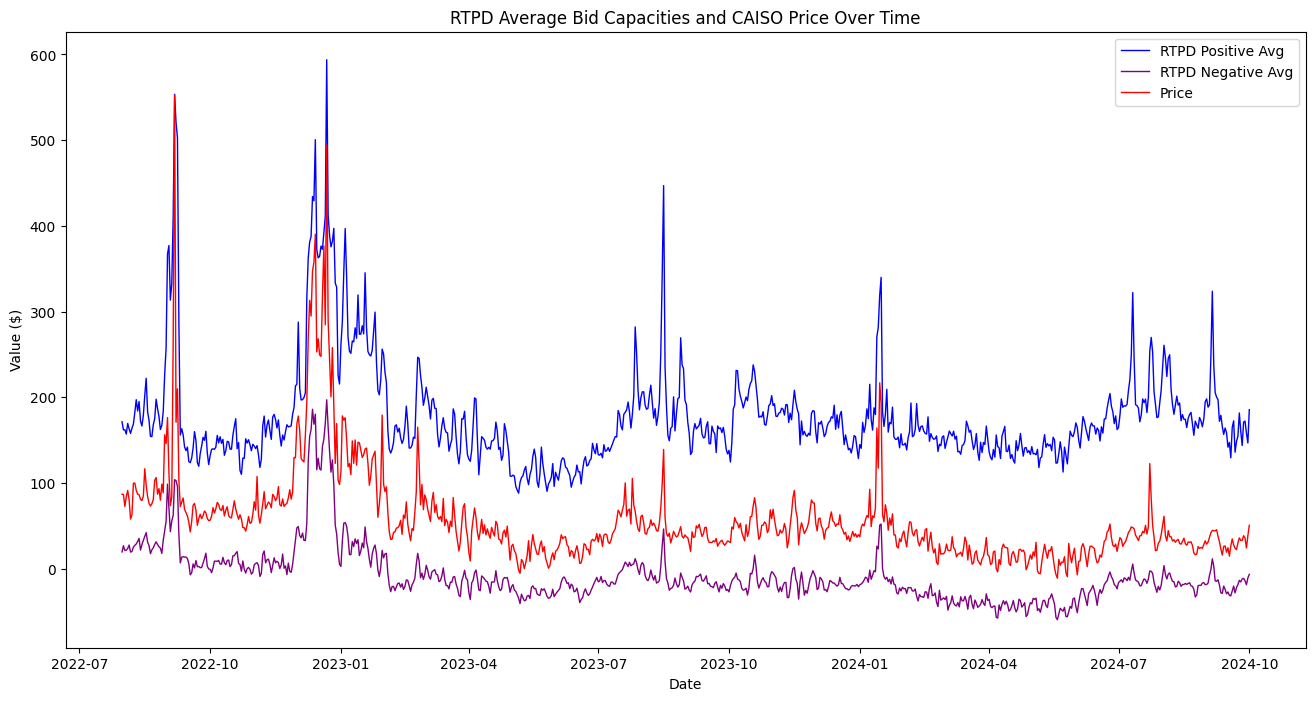

In [26]:
# Plot RTPD average bid capacities and price
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot RTPD positive and negative average bid capacities
ax1.plot(
    df_weighted_daily.index,
    df_weighted_daily["bid_rtpd_pos_avg"],
    label="RTPD Positive Avg",
    color="blue",
    linewidth=1,
)
ax1.plot(
    df_weighted_daily.index,
    df_weighted_daily["bid_rtpd_neg_avg"],
    label="RTPD Negative Avg",
    color="purple",
    linewidth=1,
)

# Plot price
ax1.plot(
    df_weighted_daily.index,
    df_weighted_daily["price"],
    label="Price",
    color="red",
    linewidth=1,
    alpha=1,
)

# Set title and labels for the y-axis
ax1.set_title("RTPD Average Bid Capacities and CAISO Price Over Time")
ax1.set_xlabel("Date")
ax1.set_ylabel("Value ($)")

# Add legend
ax1.legend(loc="upper right")

plt.show()

In [45]:
print(df.resample(AGGREGATION_GRANULARITY).min())

            tot_energy_ifm  tot_energy_ruc  tot_energy_rtpd  tot_energy_rtd  \
datetime                                                                      
2022-07-31         -1400.0         -1400.0          -1161.0         -1205.0   
2022-08-01         -1014.0         -1014.0           -879.0          -839.0   
2022-08-02         -1341.0         -1341.0           -963.0          -956.0   
2022-08-03         -1211.0         -1211.0          -1256.0         -1156.0   
2022-08-04          -917.0          -917.0          -1055.0         -1180.0   
...                    ...             ...              ...             ...   
2024-09-27         -4396.0         -4396.0          -6046.0         -5658.0   
2024-09-28         -4593.0         -4593.0          -6255.0         -6045.0   
2024-09-29         -4761.0         -4761.0          -6266.0         -6392.0   
2024-09-30         -4798.0         -4798.0          -5559.0         -5684.0   
2024-10-01         -5463.0         -5463.0          

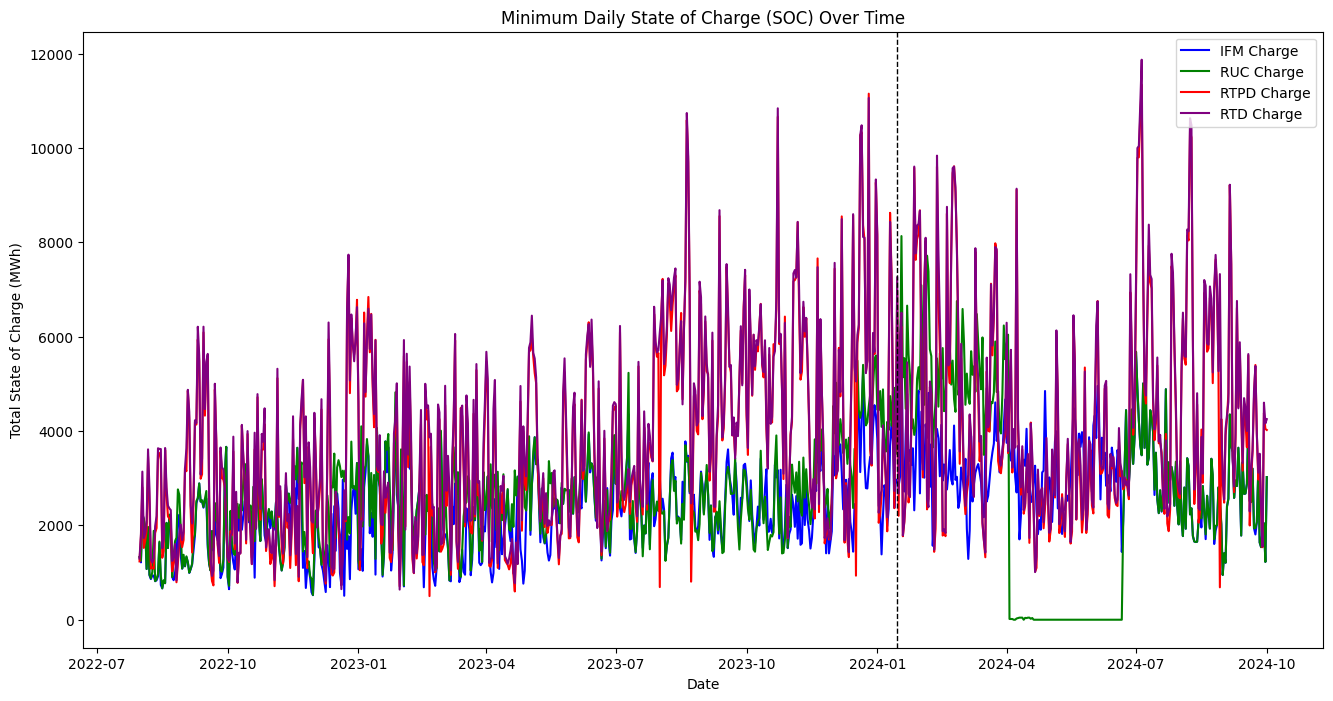

In [57]:
# Aggregate daily SOE
df_daily_soe = df.resample(AGGREGATION_GRANULARITY).min()

# # Filter for January 2024
# df_daily_soe = df_daily_soe.loc["2024-01-01":"2024-01-31"]

# Plot daily SOE
fig, ax = plt.subplots(figsize=(16, 8))

# Plot each SOE component
ax.plot(df_daily_soe.index, df_daily_soe["tot_charge_ifm"], label="IFM Charge", color="blue")
ax.plot(df_daily_soe.index, df_daily_soe["tot_charge_ruc"], label="RUC Charge", color="green")
ax.plot(df_daily_soe.index, df_daily_soe["tot_charge_rtpd"], label="RTPD Charge", color="red")
ax.plot(df_daily_soe.index, df_daily_soe["tot_charge_rtd"], label="RTD Charge", color="purple")

# Plot a vertical line on January 15, 2024
ax.axvline(pd.Timestamp("2024-01-15"), color="black", linestyle="--", linewidth=1)

# Set title and labels
ax.set_title("Minimum Daily State of Charge (SOC) Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Total State of Charge (MWh)")

# Add legend
ax.legend(loc="upper right")

plt.show()

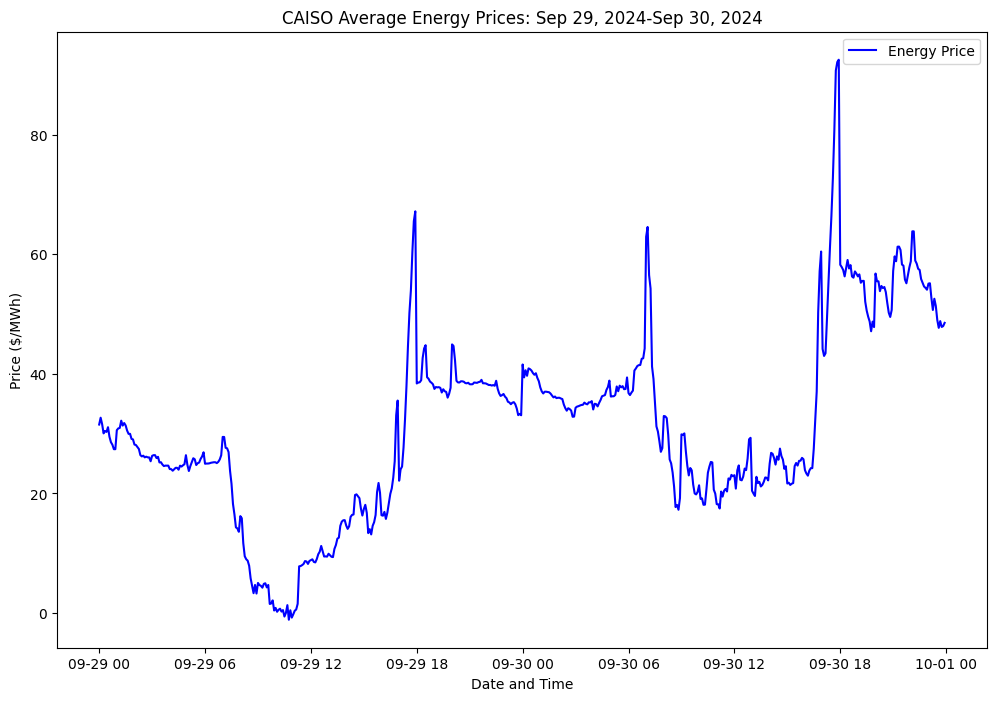

In [61]:
# Define the date range for the two days
start_date = "2024-09-29"
end_date = "2024-09-30"

# Filter the dataframe for the specified date range
df_two_days = caiso_avg_price_df.loc[start_date:end_date]

# Plot the energy prices for the two days
plt.figure(figsize=(12, 8))
plt.plot(df_two_days.index, df_two_days["price"], label="Energy Price", color="blue")

# Set title and labels
plt.title("CAISO Average Energy Prices: Sep 29, 2024-Sep 30, 2024")
plt.xlabel("Date and Time")
plt.ylabel("Price ($/MWh)")

# Add legend
plt.legend(loc="upper right")

plt.show()